# CA2 pyspark analysis and EDA 

# Notebook Structure 

- 1. Data is read in from csv files and stored in MongoDB.

- 2. Data is read in from MongoDB, stored as pandas dataframes and          converted to spark datframes, there was an issue with reading from      MongoDB directly into spark. 

- 3. Data is analysed through pyspark. 

- 4. Stock tweet data is read in, cleaned and polarity scores are created.

- 5. Stock price data and stock tweet datasets are joined together, based on the the stock price data, if there are multiple stock tweets for thatday, the average is taken and used.

- 6. Values are imputed for missing polarity scores, as there are many missing values, ad the data is not linear, more advanced techniques such as knn and random forest imputation methods are used. 

- 7. Data is saved aas final_data.csv for further analysis and saved once again in MongoDB

## The datasets are related to FAANG companies 
- Facebook 
- Amazon
- Apple 
- Netflix
- Google 

# The data is analysed and preprocessed in this order for consistency 

In [1]:
#Importing libraries 
import os 
import pandas as pd
from pymongo import MongoClient
from pyspark.sql.types import StructType, StructField, FloatType, DateType, StringType
from pyspark.sql.functions import col, to_timestamp
import matplotlib.pyplot as plt 
import pyspark.sql.functions as fn
from pyspark.sql import SparkSession
from pyspark import SparkConf


#print(os.getcwd())

In [2]:
# Downgrading pandas to work with pyspark,
# there were some compatability issues  

#!pip install pandas==1.5.3


## Reading in the raw data into MongoDB for initial storage

## Storing data in MONGODB

In [3]:
# MongoDB connection details
username = "bdsp1"
password = "bdsp1"
host = "127.0.0.1"
port = 27017
database_name = "bdsp1"
collection_name = "csvdata"  # New collection for the CSV data

# Connect to MongoDB with correct authSource
client = MongoClient(f"mongodb://{username}:{password}@{host}:{port}/?authSource={database_name}")

# Access the database and collection
db = client[database_name]
collection = db[collection_name]

# Optional: Clear the collection before inserting new data
collection.delete_many({})


In [4]:
# Get all CSV files in the same directory as this script
csv_files = [f for f in os.listdir('.') if f.endswith('.csv')]

try:
    for file in csv_files:
        company_name = os.path.splitext(file)[0]  # Extract company name from filename
        print(f"Reading and inserting: {file}")
        df = pd.read_csv(file)

        # Add a 'company' column to identify the source
        df['company'] = company_name

        records = df.to_dict(orient='records')
        
        if records:
            result = collection.insert_many(records)
            print(f"Inserted {len(result.inserted_ids)} records from {file}")
        else:
            print(f"No records found in {file}")

    # Display some of the inserted documents as a sample
    print("\nSample of Inserted Documents:")
    for doc in collection.find().limit(10):
        print(doc)

except Exception as e:
    print(f"An error occurred: {e}")

# Close the MongoDB connection
#client.close()


Reading and inserting: GOOG.csv
Inserted 254 records from GOOG.csv
Reading and inserting: final_amzn.csv
Inserted 254 records from final_amzn.csv
Reading and inserting: stocktweet.csv
Inserted 10000 records from stocktweet.csv
Reading and inserting: AAPL.csv
Inserted 254 records from AAPL.csv
Reading and inserting: final_goog.csv
Inserted 254 records from final_goog.csv
Reading and inserting: final_meta.csv
Inserted 254 records from final_meta.csv
Reading and inserting: final_nflx.csv
Inserted 254 records from final_nflx.csv
Reading and inserting: final_aapl.csv
Inserted 254 records from final_aapl.csv
Reading and inserting: final.csv
Inserted 254 records from final.csv
Reading and inserting: NFLX.csv
Inserted 254 records from NFLX.csv
Reading and inserting: AMZN.csv
Inserted 254 records from AMZN.csv
Reading and inserting: META.csv
Inserted 254 records from META.csv

Sample of Inserted Documents:
{'_id': ObjectId('6826f490992e4020cc9a9bac'), 'Date': '2019-12-31', 'Open': 66.5055007934

## Reading in the data and storing it as a spark df  

In [5]:
# Configuring Spark session 
conf = (
    SparkConf()
    .set("spark.executor.memory", "2g")          # Allocate 2 GB of memory to each executor
    .set("spark.driver.memory", "2g")            # Allocate 2 GB of memory to the driver
    .set("spark.executor.cores", "2")            # Use 2 cores for parallel task execution
    .set("spark.sql.shuffle.partitions", "50")   # Set number of partitions during shuffles
    .set("spark.default.paralleslism", "50")     # (Typo: should be 'parallelism') Number of tasks for distributed operations
)

#Get existing sparl session and apply configurations 
sc = SparkSession.getActiveSession()

if sc:
    print("====== Spark session info=====")
    print(f"App Name:{sc.sparkContext.appName}")
    print(f"Master:{sc.sparkContext.master}")
    print(f"Spark UI:{sc.sparkContext.uiWebUrl}")
    print(f"Shuffle Partitions:{sc.conf.get('spark.sql.shuffle.partitions')}")
else:
    print("No active spark session found ")


====== Spark session info=====
App Name:PySparkShell
Master:local[*]
Spark UI:http://10.0.2.15:4040
Shuffle Partitions:200


- The current Spark session is running in local mode with full use of     available CPU cores (local[*]). 

- This is suitable for development and testing purposes on a personal     machine. The Spark UI provides valuable insight into task execution,   and the use of 50 shuffle partitions indicates default Spark           settings were applied.

# Tests for efficiency for optimal number of partitions will be done 

## ISSUES with JAR connector 

MongoDB Connector Issue and Workaround
- While attempting to use the MongoDB Spark Connector (typically provided as a .jar file such as mongo-spark-connector), I encountered persistent issues integrating it into my Spark session. Despite correctly specifying the path to the JAR file in the spark.jars configuration, Spark was unable to establish a connection with MongoDB. This caused failures during data loading and schema inference, particularly due to type compatibility problems involving fields like _id (of type ObjectId) that Spark could not infer correctly.


- After multiple unsuccessful attempts to resolve the issue—including validating the compatibility between the JAR, PySpark, and MongoDB versions.


- I decided to implement a workaround. Instead of reading the data directly into Spark, I first imported it into a Pandas DataFrame using pymongo. Once loaded into Pandas, I was then able to convert the cleaned DataFrame into a Spark DataFrame for further processing.


- This approach allowed me to continue with the analysis while bypassing the JAR-related integration issue.
- Although it introduces an extra step and some performance trade-offs, it was an effective solution for the scope of this project.

In [6]:
# 
def read_faang_data_from_mongodb(username, password, host, port, database_name, collection_name, companies):
    # Connect to MongoDB
    client = MongoClient(f"mongodb://{username}:{password}@{host}:{port}/?authSource={database_name}")
    db = client[database_name]
    collection = db[collection_name]

    faang_data = {}

    for company in companies:
        print(f"Reading data for: {company}")
        # Query documents for the company
        query = {"company": company}
        documents = list(collection.find(query))

        # Convert to pandas DataFrame
        if documents:
            df = pd.DataFrame(documents)
            faang_data[company] = df
            print(f"Loaded {len(df)} rows for {company}")
        else:
            print(f"No data found for {company}")
            faang_data[company] = pd.DataFrame()  # Empty dataframe

    client.close()
    return faang_data


In [7]:
#Reading back in the data from MongoDB

companies = ["META", "AAPL", "AMZN", "NFLX", "GOOG","stocktweet"]

faang_dfs = read_faang_data_from_mongodb(
    username="bdsp1",
    password="bdsp1",
    host="127.0.0.1",
    port=27017,
    database_name="bdsp1",
    collection_name="csvdata",
    companies=companies
)

# Example: Display first few rows of Netflix data
faang_dfs["GOOG"].head()

Reading data for: META
Loaded 254 rows for META
Reading data for: AAPL
Loaded 254 rows for AAPL
Reading data for: AMZN
Loaded 254 rows for AMZN
Reading data for: NFLX
Loaded 254 rows for NFLX
Reading data for: GOOG
Loaded 254 rows for GOOG
Reading data for: stocktweet
Loaded 10000 rows for stocktweet


,_id,Date,Open,High,Low,Close,Adj Close,Volume,company
0,6826f490992e4020cc9a9bac,2019-12-31,66.505501,66.900002,66.454247,66.850998,66.850998,19236000,GOOG
1,6826f490992e4020cc9a9bad,2020-01-02,67.077499,68.406998,67.077499,68.368500,68.368500,28132000,GOOG
2,6826f490992e4020cc9a9bae,2020-01-03,67.392998,68.625000,67.277199,68.032997,68.032997,23728000,GOOG
3,6826f490992e4020cc9a9baf,2020-01-06,67.500000,69.824997,67.500000,69.710503,69.710503,34646000,GOOG
4,6826f490992e4020cc9a9bb0,2020-01-07,69.897003,70.149498,69.518997,69.667000,69.667000,30054000,GOOG


In [8]:
# Function to convert Pandas DataFrame to Spark DataFrame
def convert_pandas_to_spark(pandas_df):
    #Dropping "_id" field
    if "_id" in pandas_df.columns:
        pandas_df = pandas_df.drop("_id",axis =1)
    # Convert the given Pandas DataFrame to a Spark DataFrame
    if not pandas_df.empty:
        spark_df = spark.createDataFrame(pandas_df)
        return spark_df
    else:
        print("The provided DataFrame is empty, cannot convert to Spark DataFrame.")
        return None


# EDA 

# Facebook

In [9]:
# Convert the Pandas DataFrame of 'NFLX' (Netflix) to Spark DataFrame
spark_meta = convert_pandas_to_spark(faang_dfs["META"])

# Display the schema and first few rows of the Spark DataFrame for NFLX
if spark_meta:
    spark_meta.printSchema()
    spark_meta.show(5)
    spark_meta.cache() # caching the df to improve performance as it is stored in memory

/usr/local/spark/python/pyspark/sql/pandas/conversion.py:474: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():
/usr/local/spark/python/pyspark/sql/pandas/conversion.py:486: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():


root
 |-- Date: string (nullable = true)
 |-- Open: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- Adj Close: double (nullable = true)
 |-- Volume: long (nullable = true)
 |-- company: string (nullable = true)



+----------+------------------+------------------+-----------------+------------------+------------------+--------+-------+
|      Date|              Open|              High|              Low|             Close|         Adj Close|  Volume|company|
+----------+------------------+------------------+-----------------+------------------+------------------+--------+-------+
|2019-12-31|             204.0|205.55999755859372|203.6000061035156|            205.25|            205.25| 8953500|   META|
|2020-01-02|            206.75| 209.7899932861328|206.2700042724609|209.77999877929688|209.77999877929688|12077100|   META|
|2020-01-03| 207.2100067138672| 210.3999938964844|206.9499969482422| 208.6699981689453| 208.6699981689453|11188400|   META|
|2020-01-06| 206.6999969482422|212.77999877929688|206.5200042724609| 212.6000061035156| 212.6000061035156|17058900|   META|
|2020-01-07|212.82000732421875| 214.5800018310547|           211.75|213.05999755859372|213.05999755859372|14912400|   META|
+-------

In [10]:
# observing missing and distinct values 
print(f"Count of rows: {spark_meta.count()}")
print(f"Count of distinct rows: {spark_meta.distinct().count()}")

Count of rows: 254


Count of distinct rows: 254


## There are no duplicate rows 

# Descriptive statistics 

# Understanding the data 
The sumamry statistics presented will provides a comprehensive view of
the stocks performance across hte observed period. 
These values help us to understand the central tendencies, variability and extreme values of the stocks characteristics, including, High, Low ,Open etc..

In [11]:
#Descriptive stats on numerical columns 
numerical = ['open','High', 'Low', 'Close','volume']
spark_meta.describe(numerical).show()

+-------+------------------+------------------+------------------+------------------+--------------------+
|summary|              open|              High|               Low|             Close|              volume|
+-------+------------------+------------------+------------------+------------------+--------------------+
|  count|               254|               254|               254|               254|                 254|
|   mean|234.22921278345302|237.81244160809854| 230.6829926498293| 234.4355120921698|2.2393174409448817E7|
| stddev|38.753804305447474| 38.85538549738968| 38.49134932572285|38.533340652678824|1.0414879188782338E7|
|    min|            139.75|148.17999267578125|137.10000610351562|146.00999450683594|             6702000|
|    max| 300.1600036621094| 304.6700134277344|293.04998779296875| 303.9100036621094|            76343900|
+-------+------------------+------------------+------------------+------------------+--------------------+



## Calculating Skewness for META

In [12]:
spark_meta.agg({'Open':'skewness','High':'skewness','Low':'skewness','Close':'skewness','volume':'skewness'}).show()

+-------------------+-------------------+-------------------+--------------------+-----------------+
|     skewness(High)|    skewness(Close)|     skewness(Open)|       skewness(Low)| skewness(volume)|
+-------------------+-------------------+-------------------+--------------------+-----------------+
|-0.3914626964636027|-0.4386610662881129|-0.4357273334250091|-0.49568143671815534|2.015664076755475|
+-------------------+-------------------+-------------------+--------------------+-----------------+



# Evaluation 
The skewness analysis reveals that Netflix’s price data follows a relatively balanced distribution with mild asymmetry with values around -0.4 indicating a slightly negative skew, while trading volume is heavily influenced by a few high-value outliers.

This information is useful for further preprocessing steps, such as normalization or transformation, and should be considered when choosing modeling techniques that are sensitive to distribution shape (e.g., linear regression or clustering algorithms).

## Kurtosis
For stock market data, such as the close,high,low,open and volume, analysing kurtosis helps to identify:

- Volatility: Understanding how volatile the stock is be examining extreme price fluctuations. High kurtosis in the close, or high prices could indicate periods of market instability 

- Market sentiment: Extreme deviations from the normal distribution in hte colume can suggest unusual trading activity, such as panic selling or speculative trading 

- Risk Assessment: By indentifying high kurtosis, investors and analysts can assess the risk assocaiated with the stock. Stocks with high kurtosis are more likely to experience extreme price changes, positive and negative 

In [13]:
spark_meta.agg({'Open':'kurtosis','High':'kurtosis','Low':'kurtosis','Close':'kurtosis','volume':'kurtosis'}).show()

+-------------------+-------------------+------------------+-------------------+-----------------+
|     kurtosis(High)|    kurtosis(Close)|    kurtosis(Open)|      kurtosis(Low)| kurtosis(volume)|
+-------------------+-------------------+------------------+-------------------+-----------------+
|-0.8198116216464162|-0.7099557817842195|-0.744058829707543|-0.6473686437923907|6.037281038956955|
+-------------------+-------------------+------------------+-------------------+-----------------+



## calculating correlations in the data 

In [14]:
## calculating correlations in the data 
n_numerical = len(numerical)

# function to calculate correlations 
def calculate_corr(df):
    corr = []
    for i in range(n_numerical):
        temp = [None] *i
    
        for j in range(i,n_numerical):
            temp.append(df.corr(numerical[i],numerical[j]))
        corr.append(temp)
    return corr

In [15]:
#calculating correlations 
calculate_corr(spark_meta[numerical])


[[1.0,
  0.9969802472513977,
  0.9970924767681209,
  0.9935569300484995,
  -0.1539281355720172],
 [None, 1.0, 0.996301876364662, 0.9968568610174031, -0.11619073906876712],
 [None, None, 1.0, 0.9968505315385148, -0.17772917094219903],
 [None, None, None, 1.0, -0.1441861590540434],
 [None, None, None, None, 1.0]]

## outlier detection


In [16]:
def outliers(df):
    # Initialize an empty dictionary to store bounds for each column
    bounds = {}

    # Dynamically select numerical columns in the DataFrame
    numerical_cols = [col for col, dtype in df.dtypes if dtype in ['int', 'double', 'float']]

    # Calculate IQR for each numerical column
    for col in numerical_cols:
        quantiles = df.approxQuantile(col, [0.25, 0.75], 0.05)
        IQR = quantiles[1] - quantiles[0]
        bounds[col] = [quantiles[0] - 1.5 * IQR, quantiles[1] + 1.5 * IQR]

    # Identify outliers by checking if values fall outside the bounds
    outliers = df.select(*[col] + [
        (
            (df[col] < bounds[col][0]) | (df[col] > bounds[col][1])
        ).alias(col + '_o') for col in numerical_cols
    ])
    
    return outliers


In [17]:
#calculating outliers 
outliers(spark_meta).show()

+------------------+------+------+-----+-------+-----------+
|         Adj Close|Open_o|High_o|Low_o|Close_o|Adj Close_o|
+------------------+------+------+-----+-------+-----------+
|            205.25| false| false|false|  false|      false|
|209.77999877929688| false| false|false|  false|      false|
| 208.6699981689453| false| false|false|  false|      false|
| 212.6000061035156| false| false|false|  false|      false|
|213.05999755859372| false| false|false|  false|      false|
|215.22000122070312| false| false|false|  false|      false|
| 218.3000030517578| false| false|false|  false|      false|
|218.05999755859372| false| false|false|  false|      false|
|221.91000366210935| false| false|false|  false|      false|
|219.05999755859372| false| false|false|  false|      false|
| 221.1499938964844| false| false|false|  false|      false|
| 221.7700042724609| false| false|false|  false|      false|
|222.13999938964844| false| false|false|  false|      false|
|221.44000244140625| fal

## Running Transformations and actions for insights

In [18]:
#creating RDD
spark_meta_rdd = spark_meta
spark_meta_rdd.rdd.map(lambda row: (row['Date'],sum([c == None for c in row]))).collect()


[('2019-12-31', 0),
 ('2020-01-02', 0),
 ('2020-01-03', 0),
 ('2020-01-06', 0),
 ('2020-01-07', 0),
 ('2020-01-08', 0),
 ('2020-01-09', 0),
 ('2020-01-10', 0),
 ('2020-01-13', 0),
 ('2020-01-14', 0),
 ('2020-01-15', 0),
 ('2020-01-16', 0),
 ('2020-01-17', 0),
 ('2020-01-21', 0),
 ('2020-01-22', 0),
 ('2020-01-23', 0),
 ('2020-01-24', 0),
 ('2020-01-27', 0),
 ('2020-01-28', 0),
 ('2020-01-29', 0),
 ('2020-01-30', 0),
 ('2020-01-31', 0),
 ('2020-02-03', 0),
 ('2020-02-04', 0),
 ('2020-02-05', 0),
 ('2020-02-06', 0),
 ('2020-02-07', 0),
 ('2020-02-10', 0),
 ('2020-02-11', 0),
 ('2020-02-12', 0),
 ('2020-02-13', 0),
 ('2020-02-14', 0),
 ('2020-02-18', 0),
 ('2020-02-19', 0),
 ('2020-02-20', 0),
 ('2020-02-21', 0),
 ('2020-02-24', 0),
 ('2020-02-25', 0),
 ('2020-02-26', 0),
 ('2020-02-27', 0),
 ('2020-02-28', 0),
 ('2020-03-02', 0),
 ('2020-03-03', 0),
 ('2020-03-04', 0),
 ('2020-03-05', 0),
 ('2020-03-06', 0),
 ('2020-03-09', 0),
 ('2020-03-10', 0),
 ('2020-03-11', 0),
 ('2020-03-12', 0),


In [19]:
# SPark optimises for smaller datasets by using a single partition for small data, this is for efficiency,
#avoiding unecessary overheads
print(spark_meta_rdd.rdd.getNumPartitions())

2


## Laptop Specs
## CPU 
- AMD RYZEN 7 4800H with Radeon graphics -
- base speed: 2.90 GHz
- sockets:1
- cores:8 
- logical processors: 16

In [20]:
import time 

#Test time with 2 partitions 
start_time = time.time()
spark_meta_rdd.repartition(2).count()
print("Time with 2 partitions: ", time.time() -start_time)

#Test time with 4 partitions
start_time = time.time()
spark_meta_rdd.repartition(4).count()
print("Time with 4 partitions: ", time.time() - start_time)

# Test time taken with 8 partitions 
start_time = time.time()
spark_meta_rdd.repartition(8).count()
print("time with 8 partitions: ", time.time() - start_time)

Time with 2 partitions:  0.40088510513305664
Time with 4 partitions:  0.3432624340057373
time with 8 partitions:  0.4593663215637207


# Set partitions to 2 

For small datasets, fewer partitions might be more efficient, as the overhead of managing multiple partitions becomes more significant than the parallelism benefits. The system likely spends more time on partition management and task scheduling than on actual data processing with 4 or 8 partitions.


## Missing value

In [21]:
# calculating missing values 
spark_meta_rdd.agg(*[
    (1-(fn.count(c)/fn.count('*'))).alias(c + '_missing')
    for c in spark_meta_rdd.columns
]).show()

+------------+------------+------------+-----------+-------------+-----------------+--------------+---------------+
|Date_missing|Open_missing|High_missing|Low_missing|Close_missing|Adj Close_missing|Volume_missing|company_missing|
+------------+------------+------------+-----------+-------------+-----------------+--------------+---------------+
|         0.0|         0.0|         0.0|        0.0|          0.0|              0.0|           0.0|            0.0|
+------------+------------+------------+-----------+-------------+-----------------+--------------+---------------+



## There are no missing values so imputation will not be necessary

## SQL Queries 


In [22]:
# Register the temporary view
spark_meta.createOrReplaceTempView("My_temp_view")

# Query the view (case-sensitive!)
result = spark.sql("SELECT * FROM My_temp_view LIMIT 5")
result.show()
#

+----------+------------------+------------------+-----------------+------------------+------------------+--------+-------+
|      Date|              Open|              High|              Low|             Close|         Adj Close|  Volume|company|
+----------+------------------+------------------+-----------------+------------------+------------------+--------+-------+
|2019-12-31|             204.0|205.55999755859372|203.6000061035156|            205.25|            205.25| 8953500|   META|
|2020-01-02|            206.75| 209.7899932861328|206.2700042724609|209.77999877929688|209.77999877929688|12077100|   META|
|2020-01-03| 207.2100067138672| 210.3999938964844|206.9499969482422| 208.6699981689453| 208.6699981689453|11188400|   META|
|2020-01-06| 206.6999969482422|212.77999877929688|206.5200042724609| 212.6000061035156| 212.6000061035156|17058900|   META|
|2020-01-07|212.82000732421875| 214.5800018310547|           211.75|213.05999755859372|213.05999755859372|14912400|   META|
+-------

In [23]:
## Queryingthe top 5 trading days relating to colume traded 

query = """
SELECT Date,Volume
FROM My_temp_view
ORDER BY Volume DESC
LIMIT 5 
"""
result = spark.sql(query)
result.show()

+----------+--------+
|      Date|  Volume|
+----------+--------+
|2020-06-26|76343900|
|2020-08-07|72766400|
|2020-08-26|69015200|
|2020-06-29|58514300|
|2020-07-31|53005100|
+----------+--------+



In [24]:
#creating a query for percentage change 
query = """
SELECT Date,Close, previous_close,
        ((Close - previous_close) / previous_close) *100 AS percent_change
FROM(
    SELECT Date,Close,
            LAG(Close,1) OVER (ORDER BY Date) AS previous_close
    FROM My_temp_view
) AS subquery
WHERE previous_close IS NOT NULL
"""
result = spark.sql(query).show(5)


25/05/16 09:17:43 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/05/16 09:17:43 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/05/16 09:17:43 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/05/16 09:17:43 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/05/16 09:17:43 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
+----------+------------------+------------------+-------------------+
|      Date|             Close|    previous_close|     percent_change|
+----------+------------------+--

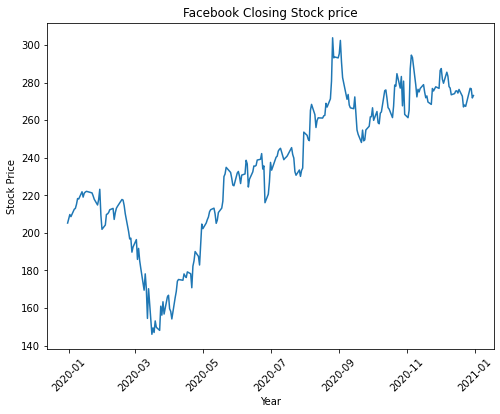

In [25]:
#Plotting the data 
pandas_meta = spark_meta_rdd.toPandas()

# converting hte Date column to Datetime 
pandas_meta['Date'] = pd.to_datetime(pandas_meta['Date'])

# Create a new column for the year
pandas_meta['Year'] = pandas_meta['Date'].dt.year

fig = plt.figure(figsize = (8,6))
plt.plot(pandas_meta['Date'], pandas_meta['Close'])
plt.ylabel('Stock Price')
plt.xlabel('Year')
plt.xticks(rotation = 45)
plt.title('Facebook Closing Stock price')
plt.show()

## AMAZON EDA

In [26]:
# Convert the Pandas DataFrame of 'NFLX' (Netflix) to Spark DataFrame
spark_amzn = convert_pandas_to_spark(faang_dfs["AMZN"])

# Display the schema and first few rows of the Spark DataFrame for NFLX
if spark_amzn:
    spark_amzn.printSchema()
    spark_amzn.show(5)

/usr/local/spark/python/pyspark/sql/pandas/conversion.py:474: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():
/usr/local/spark/python/pyspark/sql/pandas/conversion.py:486: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():


root
 |-- Date: string (nullable = true)
 |-- Open: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- Adj Close: double (nullable = true)
 |-- Volume: long (nullable = true)
 |-- company: string (nullable = true)

+----------+----------------+-----------------+-----------------+-----------------+-----------------+--------+-------+
|      Date|            Open|             High|              Low|            Close|        Adj Close|  Volume|company|
+----------+----------------+-----------------+-----------------+-----------------+-----------------+--------+-------+
|2019-12-31|92.0999984741211|92.66300201416016|91.61150360107422|92.39199829101562|92.39199829101562|50130000|   AMZN|
|2020-01-02|           93.75|94.90049743652344| 93.2074966430664|94.90049743652344|94.90049743652344|80580000|   AMZN|
|2020-01-03|93.2249984741211|94.30999755859376| 93.2249984741211|93.74849700927734|93.74849700927734|75

In [27]:
# Observing the number of rows and number of distinct rows 
print(f'Count of rows: {spark_amzn.count()}')
print(f'Count of Distinct rows: {spark_amzn.distinct().count()}')

Count of rows: 254
Count of Distinct rows: 254


## There are no Duplicate Rows 


## Descriptive Statistics


## Understanding the data 


In [28]:
# Descriptive statistics 
spark_amzn.describe(numerical).show()

+-------+------------------+------------------+------------------+------------------+-------------------+
|summary|              open|              High|               Low|             Close|             volume|
+-------+------------------+------------------+------------------+------------------+-------------------+
|  count|               254|               254|               254|               254|                254|
|   mean|133.88505121666614|135.67705322626068|131.95363773135688| 133.8787751685916|9.842891338582677E7|
| stddev|  27.6296170426755|27.792147498113273|27.046225766961747|27.359174221901483|3.956220167822858E7|
|    min| 82.07550048828125| 87.97250366210938| 81.30149841308594| 83.83049774169922|           29038000|
|    max|177.35000610351562| 177.6125030517578|174.33450317382812|176.57249450683594|          311346000|
+-------+------------------+------------------+------------------+------------------+-------------------+



## Calculating Skewness 


In [29]:
## Calculating Skewness 
spark_amzn.agg({"open":"skewness","High":"skewness","Low":"skewness","Close":"skewness","volume":"skewness"}).show()

+--------------------+-------------------+-------------------+-------------------+------------------+
|      skewness(open)|     skewness(High)|    skewness(Close)|      skewness(Low)|  skewness(volume)|
+--------------------+-------------------+-------------------+-------------------+------------------+
|-0.30406092591676176|-0.3028355661305714|-0.3093157355251768|-0.3137339697005115|1.4894626917327956|
+--------------------+-------------------+-------------------+-------------------+------------------+



## Calculating Kurtosis 


In [30]:
## Calculating Kurtosis
spark_amzn.agg({"open":"kurtosis","high":"kurtosis","Close":"kurtosis","Low":"kurtosis","volume":"kurtosis"}).show()


+-------------------+-------------------+-------------------+------------------+-------------------+
|     kurtosis(open)|    kurtosis(Close)|      kurtosis(Low)|  kurtosis(volume)|     kurtosis(high)|
+-------------------+-------------------+-------------------+------------------+-------------------+
|-1.4728684300349715|-1.4700532446460033|-1.4563617779359335|3.6114148295997452|-1.4870063064305372|
+-------------------+-------------------+-------------------+------------------+-------------------+



## Calculating Correlations

In [31]:
#Calculating correlations for the numerical column through a function 
calculate_corr(spark_amzn[numerical])


[[1.0,
  0.9982803149652224,
  0.9978831152257039,
  0.9959731035156464,
  -0.15390993295741073],
 [None, 1.0, 0.9974369272999205, 0.9980579500915108, -0.12927807743105518],
 [None, None, 1.0, 0.9981537994169078, -0.18039197793229436],
 [None, None, None, 1.0, -0.15485806701952126],
 [None, None, None, None, 1.0]]

## Computing Outliers 

In [32]:
#calculating outliers 
outliers(spark_amzn).show()

+-----------------+------+------+-----+-------+-----------+
|        Adj Close|Open_o|High_o|Low_o|Close_o|Adj Close_o|
+-----------------+------+------+-----+-------+-----------+
|92.39199829101562| false| false|false|  false|      false|
|94.90049743652344| false| false|false|  false|      false|
|93.74849700927734| false| false|false|  false|      false|
| 95.1439971923828| false| false|false|  false|      false|
|95.34300231933594| false| false|false|  false|      false|
|94.59850311279295| false| false|false|  false|      false|
|95.05249786376952| false| false|false|  false|      false|
|94.15799713134766| false| false|false|  false|      false|
|94.56500244140624| false| false|false|  false|      false|
|93.47200012207033| false| false|false|  false|      false|
|93.10099792480467| false| false|false|  false|      false|
|93.89700317382812| false| false|false|  false|      false|
|93.23600006103516| false| false|false|  false|      false|
| 94.5999984741211| false| false|false| 

## Running transformations and actions 

In [33]:
# creating RDD 
spark_amzn_rdd = spark_amzn
spark_amzn_rdd.rdd.map(lambda row: (row['Date'],sum([c == None for c in row]))).collect()


[('2019-12-31', 0),
 ('2020-01-02', 0),
 ('2020-01-03', 0),
 ('2020-01-06', 0),
 ('2020-01-07', 0),
 ('2020-01-08', 0),
 ('2020-01-09', 0),
 ('2020-01-10', 0),
 ('2020-01-13', 0),
 ('2020-01-14', 0),
 ('2020-01-15', 0),
 ('2020-01-16', 0),
 ('2020-01-17', 0),
 ('2020-01-21', 0),
 ('2020-01-22', 0),
 ('2020-01-23', 0),
 ('2020-01-24', 0),
 ('2020-01-27', 0),
 ('2020-01-28', 0),
 ('2020-01-29', 0),
 ('2020-01-30', 0),
 ('2020-01-31', 0),
 ('2020-02-03', 0),
 ('2020-02-04', 0),
 ('2020-02-05', 0),
 ('2020-02-06', 0),
 ('2020-02-07', 0),
 ('2020-02-10', 0),
 ('2020-02-11', 0),
 ('2020-02-12', 0),
 ('2020-02-13', 0),
 ('2020-02-14', 0),
 ('2020-02-18', 0),
 ('2020-02-19', 0),
 ('2020-02-20', 0),
 ('2020-02-21', 0),
 ('2020-02-24', 0),
 ('2020-02-25', 0),
 ('2020-02-26', 0),
 ('2020-02-27', 0),
 ('2020-02-28', 0),
 ('2020-03-02', 0),
 ('2020-03-03', 0),
 ('2020-03-04', 0),
 ('2020-03-05', 0),
 ('2020-03-06', 0),
 ('2020-03-09', 0),
 ('2020-03-10', 0),
 ('2020-03-11', 0),
 ('2020-03-12', 0),


In [34]:
#Calculating missing values
spark_amzn_rdd.agg(*[
    (1-(fn.count(c)/fn.count('*'))).alias(c + '_missing')
    for c in spark_meta_rdd.columns
]).show()

+------------+------------+------------+-----------+-------------+-----------------+--------------+---------------+
|Date_missing|Open_missing|High_missing|Low_missing|Close_missing|Adj Close_missing|Volume_missing|company_missing|
+------------+------------+------------+-----------+-------------+-----------------+--------------+---------------+
|         0.0|         0.0|         0.0|        0.0|          0.0|              0.0|           0.0|            0.0|
+------------+------------+------------+-----------+-------------+-----------------+--------------+---------------+



## There are no missing values so imputation will not be necessary

## SQL Queries

In [35]:
# Register the temporary view
spark_amzn.createOrReplaceTempView("My_temp_view")

# Query the view (case-sensitive!)
result = spark.sql("SELECT * FROM My_temp_view LIMIT 5")
result.show()
#

+----------+----------------+-----------------+-----------------+-----------------+-----------------+--------+-------+
|      Date|            Open|             High|              Low|            Close|        Adj Close|  Volume|company|
+----------+----------------+-----------------+-----------------+-----------------+-----------------+--------+-------+
|2019-12-31|92.0999984741211|92.66300201416016|91.61150360107422|92.39199829101562|92.39199829101562|50130000|   AMZN|
|2020-01-02|           93.75|94.90049743652344| 93.2074966430664|94.90049743652344|94.90049743652344|80580000|   AMZN|
|2020-01-03|93.2249984741211|94.30999755859376| 93.2249984741211|93.74849700927734|93.74849700927734|75288000|   AMZN|
|2020-01-06|            93.0|95.18450164794922|             93.0| 95.1439971923828| 95.1439971923828|81236000|   AMZN|
|2020-01-07|95.2249984741211|95.69450378417967|94.60199737548828|95.34300231933594|95.34300231933594|80898000|   AMZN|
+----------+----------------+-----------------+-

In [36]:
## Queryingthe top 5 trading days relating to colume traded 

query = """
SELECT Date,Volume
FROM My_temp_view
ORDER BY Volume DESC
LIMIT 5 
"""
result = spark.sql(query)
result.show()

+----------+---------+
|      Date|   Volume|
+----------+---------+
|2020-01-31|311346000|
|2020-04-16|240764000|
|2020-03-12|226924000|
|2020-03-17|218342000|
|2020-03-19|207998000|
+----------+---------+



In [37]:
#Creating a query taht shows percentage change 
query = """
SELECT Date,Close, previous_close,
        ((Close - previous_close) / previous_close) *100 AS percent_change
FROM(
    SELECT Date,Close,
            LAG(Close,1) OVER (ORDER BY Date) AS previous_close
    FROM My_temp_view
) AS subquery
WHERE previous_close IS NOT NULL
"""
result = spark.sql(query).show(5)

25/05/16 09:17:54 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/05/16 09:17:54 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/05/16 09:17:54 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/05/16 09:17:54 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/05/16 09:17:54 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
+----------+-----------------+-----------------+-------------------+
|      Date|            Close|   previous_close|     percent_change|
+----------+-----------------+-------

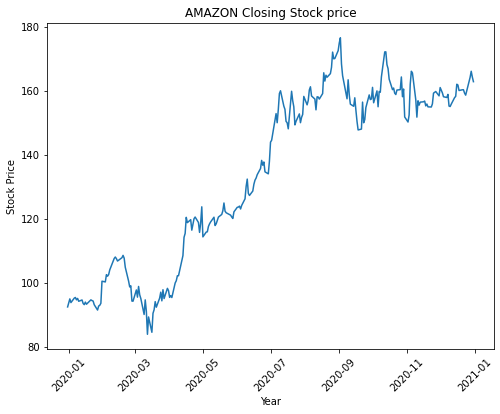

In [38]:
#Plotting the data 
pandas_amzn = spark_amzn_rdd.toPandas()

# converting hte Date column to Datetime 
pandas_amzn['Date'] = pd.to_datetime(pandas_amzn['Date'])

# Create a new column for the year
pandas_amzn['Year'] = pandas_amzn['Date'].dt.year

fig = plt.figure(figsize = (8,6))
plt.plot(pandas_amzn['Date'], pandas_amzn['Close'])
plt.ylabel('Stock Price')
plt.xlabel('Year')
plt.xticks(rotation = 45)
plt.title('AMAZON Closing Stock price')
plt.show()

## APPLE EDA

In [39]:
# Convert the Pandas DataFrame of 'NFLX' (Netflix) to Spark DataFrame
spark_aapl = convert_pandas_to_spark(faang_dfs["AAPL"])

# Display the schema and first few rows of the Spark DataFrame for NFLX
if spark_aapl:
    spark_aapl.printSchema()
    spark_aapl.show(5)

/usr/local/spark/python/pyspark/sql/pandas/conversion.py:474: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():
/usr/local/spark/python/pyspark/sql/pandas/conversion.py:486: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():


root
 |-- Date: string (nullable = true)
 |-- Open: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- Adj Close: double (nullable = true)
 |-- Volume: long (nullable = true)
 |-- company: string (nullable = true)

+----------+-----------------+-----------------+-----------------+-----------------+-----------------+---------+-------+
|      Date|             Open|             High|              Low|            Close|        Adj Close|   Volume|company|
+----------+-----------------+-----------------+-----------------+-----------------+-----------------+---------+-------+
|2019-12-31|72.48249816894531|73.41999816894531|72.37999725341797| 73.4124984741211|71.52082061767578|100805600|   AAPL|
|2020-01-02|74.05999755859375| 75.1500015258789|73.79750061035156| 75.0875015258789|73.15264892578125|135480400|   AAPL|
|2020-01-03| 74.2874984741211| 75.1449966430664|           74.125|74.35749816894531|72.441459

In [40]:
# Observing the number of rows and number of distinct rows 
print(f'Count of rows: {spark_aapl.count()}')
print(f'Count of Distinct rows: {spark_aapl.distinct().count()}')

Count of rows: 254
Count of Distinct rows: 254


## There are no Duplicate Rows 


## Descriptive Statistics


## Understanding the data 


In [41]:
# Descriptive statistics 
spark_aapl.describe(numerical).show()

+-------+-----------------+-----------------+------------------+------------------+--------------------+
|summary|             open|             High|               Low|             Close|              volume|
+-------+-----------------+-----------------+------------------+------------------+--------------------+
|  count|              254|              254|               254|               254|                 254|
|   mean|95.17796276122566|96.57026571739377| 93.82802144748958| 95.26071827805887|1.5734118582677165E8|
| stddev|22.01483370752147|22.09909824629522|21.579559974631447| 21.81013692599009| 6.978351522681883E7|
|    min|57.02000045776367|           57.125| 53.15250015258789| 56.09249877929688|            46691300|
|    max|138.0500030517578|138.7899932861328|134.33999633789062|136.69000244140625|           426510000|
+-------+-----------------+-----------------+------------------+------------------+--------------------+



## Calculating Skewness 


In [42]:
## Calculating Skewness 
spark_aapl.agg({"open":"skewness","High":"skewness","Low":"skewness","Close":"skewness","volume":"skewness"}).show()

+-------------------+-------------------+-------------------+-------------------+------------------+
|     skewness(open)|     skewness(High)|    skewness(Close)|      skewness(Low)|  skewness(volume)|
+-------------------+-------------------+-------------------+-------------------+------------------+
|0.11300788740110729|0.12487584767995677|0.09987741798595641|0.08526064879340037|1.4819999575651326|
+-------------------+-------------------+-------------------+-------------------+------------------+



## Calculating Kurtosis


In [43]:
## Calculating Kurtosis
spark_aapl.agg({"open":"kurtosis","high":"kurtosis","Close":"kurtosis","Low":"kurtosis","volume":"kurtosis"}).show()

+-------------------+-------------------+------------------+------------------+-------------------+
|     kurtosis(open)|    kurtosis(Close)|     kurtosis(Low)|  kurtosis(volume)|     kurtosis(high)|
+-------------------+-------------------+------------------+------------------+-------------------+
|-1.3951829373849858|-1.4019298288185955|-1.378365652237894|2.2361323461288487|-1.4283777665956485|
+-------------------+-------------------+------------------+------------------+-------------------+



# Calculating correlations

In [44]:
#Calculating correlations for the numerical column through a function 
calculate_corr(spark_aapl[numerical])


[[1.0,
  0.9985424116590973,
  0.9978085029207164,
  0.9962895931921201,
  -0.2835687847889123],
 [None, 1.0, 0.9973905345993809, 0.9980326641930385, -0.26140596002396416],
 [None, None, 1.0, 0.9981798058122441, -0.31382324096039854],
 [None, None, None, 1.0, -0.2891210724783593],
 [None, None, None, None, 1.0]]

In [45]:
# Calculating Outliers 
outliers(spark_aapl).show()

+-----------------+------+------+-----+-------+-----------+
|        Adj Close|Open_o|High_o|Low_o|Close_o|Adj Close_o|
+-----------------+------+------+-----+-------+-----------+
|71.52082061767578| false| false|false|  false|      false|
|73.15264892578125| false| false|false|  false|      false|
|72.44145965576172| false| false|false|  false|      false|
| 73.0186767578125| false| false|false|  false|      false|
|72.67527770996094| false| false|false|  false|      false|
|73.84435272216797| false| false|false|  false|      false|
|75.41287994384766| false| false|false|  false|      false|
|75.58334350585938| false| false|false|  false|      false|
| 77.1981430053711| false| false|false|  false|      false|
|76.15571594238281| false| false|false|  false|      false|
|75.82936096191406| false| false|false|  false|      false|
|76.77922058105469| false| false|false|  false|      false|
|77.62923431396484| false| false|false|  false|      false|
|77.10316467285156| false| false|false| 

# Running transformations and actions 

In [46]:
#creating RDD
spark_aapl_rdd = spark_aapl
spark_aapl_rdd.rdd.map(lambda row: (row['Date'],sum([c == None for c in row]))).collect()

[('2019-12-31', 0),
 ('2020-01-02', 0),
 ('2020-01-03', 0),
 ('2020-01-06', 0),
 ('2020-01-07', 0),
 ('2020-01-08', 0),
 ('2020-01-09', 0),
 ('2020-01-10', 0),
 ('2020-01-13', 0),
 ('2020-01-14', 0),
 ('2020-01-15', 0),
 ('2020-01-16', 0),
 ('2020-01-17', 0),
 ('2020-01-21', 0),
 ('2020-01-22', 0),
 ('2020-01-23', 0),
 ('2020-01-24', 0),
 ('2020-01-27', 0),
 ('2020-01-28', 0),
 ('2020-01-29', 0),
 ('2020-01-30', 0),
 ('2020-01-31', 0),
 ('2020-02-03', 0),
 ('2020-02-04', 0),
 ('2020-02-05', 0),
 ('2020-02-06', 0),
 ('2020-02-07', 0),
 ('2020-02-10', 0),
 ('2020-02-11', 0),
 ('2020-02-12', 0),
 ('2020-02-13', 0),
 ('2020-02-14', 0),
 ('2020-02-18', 0),
 ('2020-02-19', 0),
 ('2020-02-20', 0),
 ('2020-02-21', 0),
 ('2020-02-24', 0),
 ('2020-02-25', 0),
 ('2020-02-26', 0),
 ('2020-02-27', 0),
 ('2020-02-28', 0),
 ('2020-03-02', 0),
 ('2020-03-03', 0),
 ('2020-03-04', 0),
 ('2020-03-05', 0),
 ('2020-03-06', 0),
 ('2020-03-09', 0),
 ('2020-03-10', 0),
 ('2020-03-11', 0),
 ('2020-03-12', 0),


In [47]:
#Calculating missing values
spark_aapl_rdd.agg(*[
    (1-(fn.count(c)/fn.count('*'))).alias(c + '_missing')
    for c in spark_meta_rdd.columns
]).show()

+------------+------------+------------+-----------+-------------+-----------------+--------------+---------------+
|Date_missing|Open_missing|High_missing|Low_missing|Close_missing|Adj Close_missing|Volume_missing|company_missing|
+------------+------------+------------+-----------+-------------+-----------------+--------------+---------------+
|         0.0|         0.0|         0.0|        0.0|          0.0|              0.0|           0.0|            0.0|
+------------+------------+------------+-----------+-------------+-----------------+--------------+---------------+



## There are no missing values so imputation will not be necessary

## SQL Queries

In [48]:
# Register the temporary view
spark_aapl.createOrReplaceTempView("My_temp_view")

# Query the view (case-sensitive!)
result = spark.sql("SELECT * FROM My_temp_view LIMIT 5")
result.show()
#

+----------+-----------------+-----------------+-----------------+-----------------+-----------------+---------+-------+
|      Date|             Open|             High|              Low|            Close|        Adj Close|   Volume|company|
+----------+-----------------+-----------------+-----------------+-----------------+-----------------+---------+-------+
|2019-12-31|72.48249816894531|73.41999816894531|72.37999725341797| 73.4124984741211|71.52082061767578|100805600|   AAPL|
|2020-01-02|74.05999755859375| 75.1500015258789|73.79750061035156| 75.0875015258789|73.15264892578125|135480400|   AAPL|
|2020-01-03| 74.2874984741211| 75.1449966430664|           74.125|74.35749816894531|72.44145965576172|146322800|   AAPL|
|2020-01-06|73.44750213623047|74.98999786376953|          73.1875|74.94999694824219| 73.0186767578125|118387200|   AAPL|
|2020-01-07|74.95999908447266| 75.2249984741211|74.37000274658203|74.59750366210938|72.67527770996094|108872000|   AAPL|
+----------+-----------------+--

In [49]:
## Queryingthe top 5 trading days relating to colume traded 

query = """
SELECT Date,Volume
FROM My_temp_view
ORDER BY Volume DESC
LIMIT 5 
"""
result = spark.sql(query)
result.show()

+----------+---------+
|      Date|   Volume|
+----------+---------+
|2020-02-28|426510000|
|2020-03-12|418474000|
|2020-03-20|401693200|
|2020-07-31|374336800|
|2020-03-13|370732000|
+----------+---------+



In [50]:
#Creating a query that shows percentage change 

query = """
SELECT Date,Close, previous_close,
        ((Close - previous_close) / previous_close) *100 AS percent_change
FROM(
    SELECT Date,Close,
            LAG(Close,1) OVER (ORDER BY Date) AS previous_close
    FROM My_temp_view
) AS subquery
WHERE previous_close IS NOT NULL
"""
result = spark.sql(query).show(5)

25/05/16 09:18:04 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/05/16 09:18:04 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/05/16 09:18:04 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/05/16 09:18:04 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/05/16 09:18:04 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
+----------+-----------------+-----------------+--------------------+
|      Date|            Close|   previous_close|      percent_change|
+----------+-----------------+-----

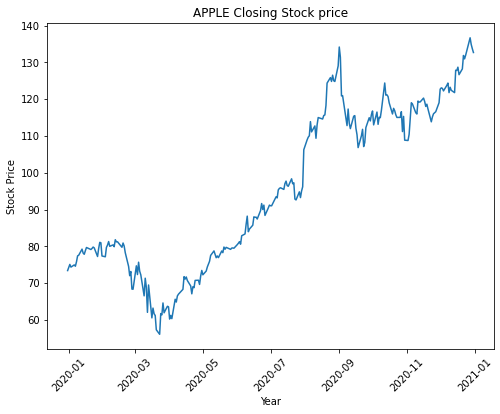

In [51]:
#Plotting the data 
pandas_aapl = spark_aapl_rdd.toPandas()

# converting hte Date column to Datetime 
pandas_aapl['Date'] = pd.to_datetime(pandas_aapl['Date'])

# Create a new column for the year
pandas_aapl['Year'] = pandas_aapl['Date'].dt.year

fig = plt.figure(figsize = (8,6))
plt.plot(pandas_aapl['Date'], pandas_aapl['Close'])
plt.ylabel('Stock Price')
plt.xlabel('Year')
plt.xticks(rotation = 45)
plt.title('APPLE Closing Stock price')
plt.show()

## Netflix EDA

In [52]:
# Convert the Pandas DataFrame of 'NFLX' (Netflix) to Spark DataFrame
spark_nflx = convert_pandas_to_spark(faang_dfs["NFLX"])

# Display the schema and first few rows of the Spark DataFrame for NFLX
if spark_nflx:
    spark_nflx.printSchema()
    spark_nflx.show(5)

/usr/local/spark/python/pyspark/sql/pandas/conversion.py:474: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():
/usr/local/spark/python/pyspark/sql/pandas/conversion.py:486: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():


root
 |-- Date: string (nullable = true)
 |-- Open: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- Adj Close: double (nullable = true)
 |-- Volume: long (nullable = true)
 |-- company: string (nullable = true)

+----------+-----------------+------------------+------------------+------------------+------------------+-------+-------+
|      Date|             Open|              High|               Low|             Close|         Adj Close| Volume|company|
+----------+-----------------+------------------+------------------+------------------+------------------+-------+-------+
|2019-12-31|            322.0| 324.9200134277344| 321.0899963378906|323.57000732421875|323.57000732421875|3713300|   NFLX|
|2020-01-02|326.1000061035156| 329.9800109863281| 324.7799987792969| 329.8099975585937| 329.8099975585937|4485800|   NFLX|
|2020-01-03|326.7799987792969| 329.8599853515625| 325.5299987792969| 325.8999938964

In [53]:
# Observing the number of rows and number of distinct rows 
print(f'Count of rows: {spark_nflx.count()}')
print(f'Count of Distinct rows: {spark_nflx.distinct().count()}')

Count of rows: 254
Count of Distinct rows: 254


## There are no Duplicate Rows 


## Descriptive Statistics


## Understanding the data 

In [54]:
# Descriptive statistics 
spark_nflx.describe(numerical).show()

+-------+------------------+------------------+-----------------+-----------------+------------------+
|summary|              open|              High|              Low|            Close|            volume|
+-------+------------------+------------------+-----------------+-----------------+------------------+
|  count|               254|               254|              254|              254|               254|
|   mean|445.65271596833475|453.81059036855623|437.9072063776452|446.3419682059701|  6921221.25984252|
| stddev| 66.39179193141493|  66.4464681315554|65.29296683945726|  65.937954881511|3971243.3386738277|
|    min| 302.3999938964844| 322.8999938964844|           290.25|298.8399963378906|           1144000|
|    max|   567.97998046875| 575.3699951171875|            541.0|556.5499877929688|          24991400|
+-------+------------------+------------------+-----------------+-----------------+------------------+



## Calculating Skewness 


In [55]:
## Calculating Skewness 
spark_nflx.agg({"open":"skewness","High":"skewness","Low":"skewness","Close":"skewness","volume":"skewness"}).show()

+-------------------+--------------------+-------------------+-------------------+------------------+
|     skewness(open)|      skewness(High)|    skewness(Close)|      skewness(Low)|  skewness(volume)|
+-------------------+--------------------+-------------------+-------------------+------------------+
|-0.4007797252753204|-0.36931542640955894|-0.4027038721200456|-0.4442032783758588|2.1662625002974414|
+-------------------+--------------------+-------------------+-------------------+------------------+



# Calculating Kurtosis


In [56]:
## Calculating Kurtosis
spark_nflx.agg({"open":"kurtosis","high":"kurtosis","Close":"kurtosis","Low":"kurtosis","volume":"kurtosis"}).show()

+-------------------+-------------------+-------------------+-----------------+-------------------+
|     kurtosis(open)|    kurtosis(Close)|      kurtosis(Low)| kurtosis(volume)|     kurtosis(high)|
+-------------------+-------------------+-------------------+-----------------+-------------------+
|-1.0714026109524903|-1.0802578385514794|-1.0657821597142672|5.623098015177064|-1.1018041899108588|
+-------------------+-------------------+-------------------+-----------------+-------------------+



# Calculating correlations

In [57]:
#Calculating correlations for the numerical column through a function 
calculate_corr(spark_nflx[numerical])


[[1.0,
  0.994028668126931,
  0.994869412981932,
  0.9873813493667721,
  -0.1696291189201572],
 [None, 1.0, 0.9928991605621255, 0.9942295253892214, -0.1275004480152775],
 [None, None, 1.0, 0.9935816656714286, -0.20017152019679393],
 [None, None, None, 1.0, -0.1565363440284375],
 [None, None, None, None, 1.0]]

# Calculating Outliers 


In [58]:
# Calculating Outliers 
outliers(spark_nflx).show()

+------------------+------+------+-----+-------+-----------+
|         Adj Close|Open_o|High_o|Low_o|Close_o|Adj Close_o|
+------------------+------+------+-----+-------+-----------+
|323.57000732421875| false| false|false|  false|      false|
| 329.8099975585937| false| false|false|  false|      false|
| 325.8999938964844| false| false|false|  false|      false|
| 335.8299865722656| false| false|false|  false|      false|
|            330.75| false| false|false|  false|      false|
|  339.260009765625| false| false|false|  false|      false|
| 335.6600036621094| false| false|false|  false|      false|
|329.04998779296875| false| false|false|  false|      false|
| 338.9200134277344| false| false|false|  false|      false|
|338.69000244140625| false| false|false|  false|      false|
|339.07000732421875| false| false|false|  false|      false|
| 338.6199951171875| false| false|false|  false|      false|
| 339.6700134277344| false| false|false|  false|      false|
| 338.1099853515625| fal

## Running transformations and actions 

In [59]:
## Running transformations and actions 
spark_nflx_rdd = spark_nflx
spark_nflx_rdd.rdd.map(lambda row: (row['Date'],sum([c == None for c in row]))).collect()

[('2019-12-31', 0),
 ('2020-01-02', 0),
 ('2020-01-03', 0),
 ('2020-01-06', 0),
 ('2020-01-07', 0),
 ('2020-01-08', 0),
 ('2020-01-09', 0),
 ('2020-01-10', 0),
 ('2020-01-13', 0),
 ('2020-01-14', 0),
 ('2020-01-15', 0),
 ('2020-01-16', 0),
 ('2020-01-17', 0),
 ('2020-01-21', 0),
 ('2020-01-22', 0),
 ('2020-01-23', 0),
 ('2020-01-24', 0),
 ('2020-01-27', 0),
 ('2020-01-28', 0),
 ('2020-01-29', 0),
 ('2020-01-30', 0),
 ('2020-01-31', 0),
 ('2020-02-03', 0),
 ('2020-02-04', 0),
 ('2020-02-05', 0),
 ('2020-02-06', 0),
 ('2020-02-07', 0),
 ('2020-02-10', 0),
 ('2020-02-11', 0),
 ('2020-02-12', 0),
 ('2020-02-13', 0),
 ('2020-02-14', 0),
 ('2020-02-18', 0),
 ('2020-02-19', 0),
 ('2020-02-20', 0),
 ('2020-02-21', 0),
 ('2020-02-24', 0),
 ('2020-02-25', 0),
 ('2020-02-26', 0),
 ('2020-02-27', 0),
 ('2020-02-28', 0),
 ('2020-03-02', 0),
 ('2020-03-03', 0),
 ('2020-03-04', 0),
 ('2020-03-05', 0),
 ('2020-03-06', 0),
 ('2020-03-09', 0),
 ('2020-03-10', 0),
 ('2020-03-11', 0),
 ('2020-03-12', 0),


In [60]:
#Calculating missing values
spark_nflx_rdd.agg(*[
    (1-(fn.count(c)/fn.count('*'))).alias(c + '_missing')
    for c in spark_meta_rdd.columns
]).show()

+------------+------------+------------+-----------+-------------+-----------------+--------------+---------------+
|Date_missing|Open_missing|High_missing|Low_missing|Close_missing|Adj Close_missing|Volume_missing|company_missing|
+------------+------------+------------+-----------+-------------+-----------------+--------------+---------------+
|         0.0|         0.0|         0.0|        0.0|          0.0|              0.0|           0.0|            0.0|
+------------+------------+------------+-----------+-------------+-----------------+--------------+---------------+



## There are no missing values so imputation will not be necessary

## SQL Queries

In [61]:
# Register the temporary view
spark_nflx.createOrReplaceTempView("My_temp_view")

# Query the view (case-sensitive!)
result = spark.sql("SELECT * FROM My_temp_view LIMIT 5")
result.show()
#

+----------+-----------------+------------------+------------------+------------------+------------------+-------+-------+
|      Date|             Open|              High|               Low|             Close|         Adj Close| Volume|company|
+----------+-----------------+------------------+------------------+------------------+------------------+-------+-------+
|2019-12-31|            322.0| 324.9200134277344| 321.0899963378906|323.57000732421875|323.57000732421875|3713300|   NFLX|
|2020-01-02|326.1000061035156| 329.9800109863281| 324.7799987792969| 329.8099975585937| 329.8099975585937|4485800|   NFLX|
|2020-01-03|326.7799987792969| 329.8599853515625| 325.5299987792969| 325.8999938964844| 325.8999938964844|3806900|   NFLX|
|2020-01-06|323.1199951171875| 336.3599853515625|321.20001220703125| 335.8299865722656| 335.8299865722656|5663100|   NFLX|
|2020-01-07|336.4700012207031|336.70001220703125|330.29998779296875|            330.75|            330.75|4703200|   NFLX|
+----------+----

In [62]:
## Queryingthe top 5 trading days relating to colume traded 

query = """
SELECT Date,Volume
FROM My_temp_view
ORDER BY Volume DESC
LIMIT 5 
"""
result = spark.sql(query)
result.show()

+----------+--------+
|      Date|  Volume|
+----------+--------+
|2020-07-17|24991400|
|2020-07-16|24499000|
|2020-04-21|23177600|
|2020-01-22|21730000|
|2020-07-10|21605600|
+----------+--------+



In [63]:
#Creating a query that shows percentage change 

query = """
SELECT Date,Close, previous_close,
        ((Close - previous_close) / previous_close) *100 AS percent_change
FROM(
    SELECT Date,Close,
            LAG(Close,1) OVER (ORDER BY Date) AS previous_close
    FROM My_temp_view
) AS subquery
WHERE previous_close IS NOT NULL
"""
result = spark.sql(query).show(5)

25/05/16 09:18:12 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/05/16 09:18:12 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/05/16 09:18:12 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/05/16 09:18:12 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/05/16 09:18:12 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
+----------+-----------------+------------------+-------------------+
|      Date|            Close|    previous_close|     percent_change|
+----------+-----------------+-----

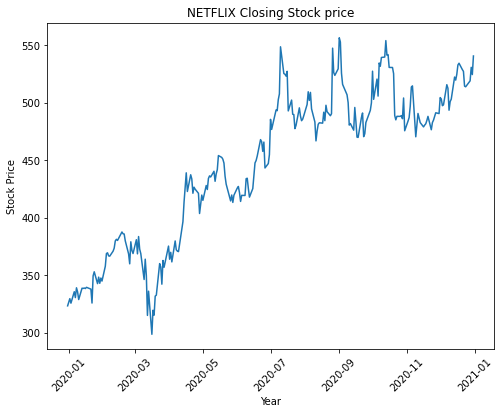

In [64]:
#Plotting the data 
pandas_nflx = spark_nflx_rdd.toPandas()

# converting hte Date column to Datetime 
pandas_nflx['Date'] = pd.to_datetime(pandas_nflx['Date'])

# Create a new column for the year
pandas_nflx['Year'] = pandas_nflx['Date'].dt.year

fig = plt.figure(figsize = (8,6))
plt.plot(pandas_nflx['Date'], pandas_nflx['Close'])
plt.ylabel('Stock Price')
plt.xlabel('Year')
plt.xticks(rotation = 45)
plt.title('NETFLIX Closing Stock price')
plt.show()

## GOOGLE EDA

In [65]:
# Convert the Pandas DataFrame of 'NFLX' (Netflix) to Spark DataFrame
spark_goog = convert_pandas_to_spark(faang_dfs["GOOG"])

# Display the schema and first few rows of the Spark DataFrame for NFLX
if spark_goog:
    spark_goog.printSchema()
    spark_goog.show(5)

/usr/local/spark/python/pyspark/sql/pandas/conversion.py:474: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():
/usr/local/spark/python/pyspark/sql/pandas/conversion.py:486: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():


root
 |-- Date: string (nullable = true)
 |-- Open: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- Adj Close: double (nullable = true)
 |-- Volume: long (nullable = true)
 |-- company: string (nullable = true)

+----------+-----------------+-----------------+-----------------+-----------------+-----------------+--------+-------+
|      Date|             Open|             High|              Low|            Close|        Adj Close|  Volume|company|
+----------+-----------------+-----------------+-----------------+-----------------+-----------------+--------+-------+
|2019-12-31|66.50550079345703| 66.9000015258789| 66.4542465209961|66.85099792480469|66.85099792480469|19236000|   GOOG|
|2020-01-02|67.07749938964844|68.40699768066406|67.07749938964844|68.36849975585938|68.36849975585938|28132000|   GOOG|
|2020-01-03|67.39299774169922|           68.625| 67.2771987915039|68.03299713134766|68.03299713134

In [66]:
# Observing the number of rows and number of distinct rows 
print(f'Count of rows: {spark_goog.count()}')
print(f'Count of Distinct rows: {spark_goog.distinct().count()}')

Count of rows: 254
Count of Distinct rows: 254


## There are no Duplicate Rows 


## Descriptive Statistics


## Understanding the data 

In [67]:
# Descriptive statistics 
spark_goog.describe(numerical).show()

+-------+-----------------+-----------------+-----------------+-----------------+--------------------+
|summary|             open|             High|              Low|            Close|              volume|
+-------+-----------------+-----------------+-----------------+-----------------+--------------------+
|  count|              254|              254|              254|              254|                 254|
|   mean|73.94891055550163|74.92724248931164|73.07726763928031|74.04176856213667|3.7760385826771654E7|
| stddev|8.834613819714725|8.740315159874395|8.938779810643892| 8.79266293329415|1.5365176049379162E7|
|    min|52.82550048828125|53.56600189208984|50.67679977416992|52.83100128173828|             6936000|
|    max|91.22599792480467|92.36000061035156|91.13249969482422|91.39949798583984|            86582000|
+-------+-----------------+-----------------+-----------------+-----------------+--------------------+



## Calculating Skewness 


In [68]:
## Calculating Skewness 
spark_goog.agg({"open":"skewness","High":"skewness","Low":"skewness","Close":"skewness","volume":"skewness"}).show()

+-------------------+--------------------+--------------------+--------------------+------------------+
|     skewness(open)|      skewness(High)|     skewness(Close)|       skewness(Low)|  skewness(volume)|
+-------------------+--------------------+--------------------+--------------------+------------------+
|-0.0996475969338819|-0.03424466998390147|-0.09152025338187336|-0.15494152226394844|1.4346505939027043|
+-------------------+--------------------+--------------------+--------------------+------------------+



## Calculating Kurtosis


In [69]:
## Calculating Kurtosis
spark_goog.agg({"open":"kurtosis","high":"kurtosis","Close":"kurtosis","Low":"kurtosis","volume":"kurtosis"}).show()

+--------------------+--------------------+--------------------+------------------+------------------+
|      kurtosis(open)|     kurtosis(Close)|       kurtosis(Low)|  kurtosis(volume)|    kurtosis(high)|
+--------------------+--------------------+--------------------+------------------+------------------+
|-0.17636390896859622|-0.16680276009755302|-0.09838517456071783|1.6480578443482585|-0.256089466304001|
+--------------------+--------------------+--------------------+------------------+------------------+



# Calculating correlations

In [70]:
#Calculating correlations for the numerical column through a function 
calculate_corr(spark_goog[numerical])


[[1.0,
  0.9964766735915901,
  0.9955328322879018,
  0.9912406464185547,
  -0.42554875947364185],
 [None, 1.0, 0.9952334331709339, 0.9954159471472528, -0.405656743370365],
 [None, None, 1.0, 0.9964044861328626, -0.4633131677959319],
 [None, None, None, 1.0, -0.4416569961365752],
 [None, None, None, None, 1.0]]

# Calculating Outliers 


In [71]:
# Calculating Outliers 
outliers(spark_goog).show()

+-----------------+------+------+-----+-------+-----------+
|        Adj Close|Open_o|High_o|Low_o|Close_o|Adj Close_o|
+-----------------+------+------+-----+-------+-----------+
|66.85099792480469| false| false|false|  false|      false|
|68.36849975585938| false| false|false|  false|      false|
|68.03299713134766| false| false|false|  false|      false|
|69.71050262451172| false| false|false|  false|      false|
|69.66699981689453| false| false|false|  false|      false|
|70.21600341796875| false| false|false|  false|      false|
|70.99150085449219| false| false|false|  false|      false|
|71.48650360107422| false| false|false|  false|      false|
|71.96150207519531| false| false|false|  false|      false|
|71.54399871826172| false| false|false|  false|      false|
|71.95999908447266| false| false|false|  false|      false|
|72.58499908447266| false| false|false|  false|      false|
|74.01950073242188| false| false|false|  false|      false|
|74.22000122070312| false| false|false| 

## Running transformations and actions 


In [72]:
## Running transformations and actions 
spark_goog_rdd = spark_goog
spark_goog_rdd.rdd.map(lambda row: (row['Date'],sum([c == None for c in row]))).collect()

[('2019-12-31', 0),
 ('2020-01-02', 0),
 ('2020-01-03', 0),
 ('2020-01-06', 0),
 ('2020-01-07', 0),
 ('2020-01-08', 0),
 ('2020-01-09', 0),
 ('2020-01-10', 0),
 ('2020-01-13', 0),
 ('2020-01-14', 0),
 ('2020-01-15', 0),
 ('2020-01-16', 0),
 ('2020-01-17', 0),
 ('2020-01-21', 0),
 ('2020-01-22', 0),
 ('2020-01-23', 0),
 ('2020-01-24', 0),
 ('2020-01-27', 0),
 ('2020-01-28', 0),
 ('2020-01-29', 0),
 ('2020-01-30', 0),
 ('2020-01-31', 0),
 ('2020-02-03', 0),
 ('2020-02-04', 0),
 ('2020-02-05', 0),
 ('2020-02-06', 0),
 ('2020-02-07', 0),
 ('2020-02-10', 0),
 ('2020-02-11', 0),
 ('2020-02-12', 0),
 ('2020-02-13', 0),
 ('2020-02-14', 0),
 ('2020-02-18', 0),
 ('2020-02-19', 0),
 ('2020-02-20', 0),
 ('2020-02-21', 0),
 ('2020-02-24', 0),
 ('2020-02-25', 0),
 ('2020-02-26', 0),
 ('2020-02-27', 0),
 ('2020-02-28', 0),
 ('2020-03-02', 0),
 ('2020-03-03', 0),
 ('2020-03-04', 0),
 ('2020-03-05', 0),
 ('2020-03-06', 0),
 ('2020-03-09', 0),
 ('2020-03-10', 0),
 ('2020-03-11', 0),
 ('2020-03-12', 0),


In [73]:
#Calculating missing values
spark_goog_rdd.agg(*[
    (1-(fn.count(c)/fn.count('*'))).alias(c + '_missing')
    for c in spark_meta_rdd.columns
]).show()

+------------+------------+------------+-----------+-------------+-----------------+--------------+---------------+
|Date_missing|Open_missing|High_missing|Low_missing|Close_missing|Adj Close_missing|Volume_missing|company_missing|
+------------+------------+------------+-----------+-------------+-----------------+--------------+---------------+
|         0.0|         0.0|         0.0|        0.0|          0.0|              0.0|           0.0|            0.0|
+------------+------------+------------+-----------+-------------+-----------------+--------------+---------------+



In [74]:
# Register the temporary view
spark_goog.createOrReplaceTempView("My_temp_view")

# Query the view (case-sensitive!)
result = spark.sql("SELECT * FROM My_temp_view LIMIT 5")
result.show()
#

+----------+-----------------+-----------------+-----------------+-----------------+-----------------+--------+-------+
|      Date|             Open|             High|              Low|            Close|        Adj Close|  Volume|company|
+----------+-----------------+-----------------+-----------------+-----------------+-----------------+--------+-------+
|2019-12-31|66.50550079345703| 66.9000015258789| 66.4542465209961|66.85099792480469|66.85099792480469|19236000|   GOOG|
|2020-01-02|67.07749938964844|68.40699768066406|67.07749938964844|68.36849975585938|68.36849975585938|28132000|   GOOG|
|2020-01-03|67.39299774169922|           68.625| 67.2771987915039|68.03299713134766|68.03299713134766|23728000|   GOOG|
|2020-01-06|             67.5|69.82499694824219|             67.5|69.71050262451172|69.71050262451172|34646000|   GOOG|
|2020-01-07|69.89700317382812|70.14949798583984|69.51899719238281|69.66699981689453|69.66699981689453|30054000|   GOOG|
+----------+-----------------+----------

In [75]:
## Queryingthe top 5 trading days relating to colume traded 

query = """
SELECT Date,Volume
FROM My_temp_view
ORDER BY Volume DESC
LIMIT 5 
"""
result = spark.sql(query)

result.show()

+----------+--------+
|      Date|  Volume|
+----------+--------+
|2020-10-30|86582000|
|2020-06-26|85354000|
|2020-03-16|85048000|
|2020-03-18|84668000|
|2020-03-12|84534000|
+----------+--------+



In [76]:
#Creating a query that shows percentage change 

query = """
SELECT Date,Close, previous_close,
        ((Close - previous_close) / previous_close) *100 AS percent_change
FROM(
    SELECT Date,Close,
            LAG(Close,1) OVER (ORDER BY Date) AS previous_close
    FROM My_temp_view
) AS subquery
WHERE previous_close IS NOT NULL
"""
result = spark.sql(query).show(5)

25/05/16 09:18:21 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/05/16 09:18:21 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/05/16 09:18:21 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/05/16 09:18:21 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/05/16 09:18:21 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
+----------+-----------------+-----------------+--------------------+
|      Date|            Close|   previous_close|      percent_change|
+----------+-----------------+-----

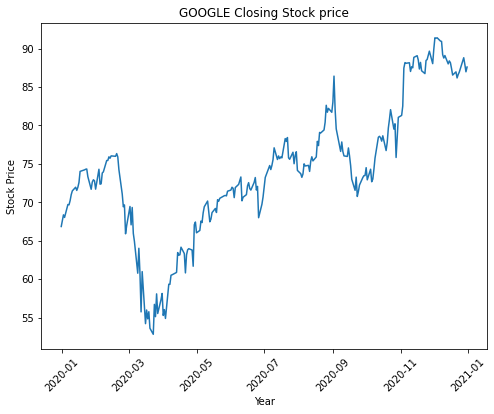

In [77]:
#Plotting the data 
pandas_goog = spark_goog_rdd.toPandas()

# converting hte Date column to Datetime 
pandas_goog['Date'] = pd.to_datetime(pandas_goog['Date'])

# Create a new column for the year
pandas_goog['Year'] = pandas_goog['Date'].dt.year

fig = plt.figure(figsize = (8,6))
plt.plot(pandas_goog['Date'], pandas_goog['Close'])
plt.ylabel('Stock Price')
plt.xlabel('Year')
plt.xticks(rotation = 45)
plt.title('GOOGLE Closing Stock price')
plt.show()

# Stock Tweets

In [78]:
#reading in the stock tweet data 
spark_tweet = convert_pandas_to_spark(faang_dfs["stocktweet"])
if spark_tweet:
    spark_tweet.printSchema()
    spark_tweet.show(10)

/usr/local/spark/python/pyspark/sql/pandas/conversion.py:474: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():
/usr/local/spark/python/pyspark/sql/pandas/conversion.py:486: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():


root
 |-- id: long (nullable = true)
 |-- date: string (nullable = true)
 |-- ticker: string (nullable = true)
 |-- tweet: string (nullable = true)
 |-- company: string (nullable = true)

+------+----------+------+--------------------+----------+
|    id|      date|ticker|               tweet|   company|
+------+----------+------+--------------------+----------+
|100001|01/01/2020|  AMZN|$AMZN Dow futures...|stocktweet|
|100002|01/01/2020|  TSLA|$TSLA Daddy's dri...|stocktweet|
|100003|01/01/2020|  AAPL|$AAPL We’ll been ...|stocktweet|
|100004|01/01/2020|  TSLA|$TSLA happy new y...|stocktweet|
|100005|01/01/2020|  TSLA|$TSLA haha just a...|stocktweet|
|100006|01/01/2020|  TSLA|$TSLA NOBODY: Gas...|stocktweet|
|100007|02/01/2020|  AAPL|$AAPL $300 calls ...|stocktweet|
|100008|02/01/2020|  AAPL|$AAPL Remember, i...|stocktweet|
|100009|02/01/2020|  AAPL|$AAPL called it, ...|stocktweet|
|100010|02/01/2020|    HD|$HD Bought more a...|stocktweet|
+------+----------+------+-------------------

In [79]:
# Observing the number of rows and number of distinct rows 
print(f'Count of rows: {spark_tweet.count()}')
print(f'Count of Distinct rows: {spark_tweet.distinct().count()}')

Count of rows: 10000
Count of Distinct rows: 10000


## For Cleaning the Text data, the dataframe will be converted into a pandas DF for more versatility

In [80]:
#importing libraries 
import seaborn as sns
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import re 
import numpy as np
import matplotlib.pyplot as plt


tweet_df = spark_tweet.toPandas()
tweet_df.tail(100)

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


,id,date,ticker,tweet,company
9900,109901,20/11/2020,AAPL,$AAPL there’s your calls. Enjoy the 🩸,stocktweet
9901,109902,24/11/2020,AAPL,$AAPL not allowed to go up👊👊👊👊,stocktweet
9902,109903,24/11/2020,PYPL,$PYPL - New high of day! 🦈,stocktweet
9903,109904,24/11/2020,CCL,$CCL coronavirus vaccine will begin to become...,stocktweet
9904,109905,24/11/2020,TSLA,$TSLA wow shorts are about to lose another 40...,stocktweet
...,...,...,...,...,...
9995,109996,31/12/2020,ABNB,"$ABNB “sugar daddy puts.” Don’t mind me, I’m j...",stocktweet
9996,109997,31/12/2020,TSLA,$TSLA \nGood news... now bears can get help wh...,stocktweet
9997,109998,31/12/2020,BABA,$BABA Who else is glad they sold in 240s yeste...,stocktweet
9998,109999,31/12/2020,CCL,$CCL $23 calls for .79 you know what to do 🥳,stocktweet


In [81]:
#filtering dataset for relevant companies 
tickers = ["AAPL", "AMZN", "NFLX", "GOOG", "GOOGL","FB"]
tweet_df = tweet_df[tweet_df['ticker'].isin(tickers)]
print(tweet_df.shape)
tweet_df.head()
tweet_df['ticker'].unique()

(2562, 5)


array(['AMZN', 'AAPL', 'GOOGL', 'NFLX', 'FB', 'GOOG'], dtype=object)

In [82]:
tweet_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2562 entries, 0 to 9987
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       2562 non-null   int64 
 1   date     2562 non-null   object
 2   ticker   2562 non-null   object
 3   tweet    2562 non-null   object
 4   company  2562 non-null   object
dtypes: int64(1), object(4)
memory usage: 120.1+ KB


In [83]:
# cconverting date column to datetime 
tweet_df['date'] = pd.to_datetime(tweet_df['date'], format = "%d/%m/%Y")


In [84]:
tweet_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2562 entries, 0 to 9987
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   id       2562 non-null   int64         
 1   date     2562 non-null   datetime64[ns]
 2   ticker   2562 non-null   object        
 3   tweet    2562 non-null   object        
 4   company  2562 non-null   object        
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 120.1+ KB


In [85]:
# Cleaning hte text data 
def clean_text(text):
    '''
        Clean the given tweet text by removing URLs, mentions,
        hashtags, special characters, and company names.

    '''
    company_names = ['amzn', 'fb','aapl','goog','nflx']
    text = re.sub(r"httpzS+|www\S+|https\S+","",text,flags = re.MULTILINE) # remove URLs
    text = re.sub(r"\@\w+|\#","",text) # remove @mentions and hashtags
    text = re.sub(r"[^A-Za-z\s]", "",text) #remove special characters
    for c in company_names:
        text = re.sub(r"\b" + c + r'\b', '', text, flags = re.IGNORECASE)
    text = text.lower().strip()
    return text 

tweet_df['clean_tweet'] = tweet_df['tweet'].apply(clean_text)
tweet_df.head()

,id,date,ticker,tweet,company,clean_tweet
0,100001,2020-01-01,AMZN,$AMZN Dow futures up by 100 points already 🥳,stocktweet,dow futures up by points already
2,100003,2020-01-01,AAPL,$AAPL We’ll been riding since last December fr...,stocktweet,well been riding since last december from wha...
6,100007,2020-01-02,AAPL,$AAPL $300 calls First trade of 2020 Congrats ...,stocktweet,calls first trade of congrats to all bulls
7,100008,2020-01-02,AAPL,"$AAPL Remember, if you short every day, one of...",stocktweet,remember if you short every day one of those d...
8,100009,2020-01-02,AAPL,"$AAPL called it, the bear comment below makes ...",stocktweet,called it the bear comment below makes me chuc...


In [86]:
#!pip install vaderSentiment


In [87]:
# running the analyzer to get polarity scores 
analyzer = SentimentIntensityAnalyzer()

tweet_df['sentiment'] = tweet_df['clean_tweet'].apply(lambda x: analyzer.polarity_scores(x)['compound'])

tweet_df.head(10)

,id,date,ticker,tweet,company,clean_tweet,sentiment
0,100001,2020-01-01,AMZN,$AMZN Dow futures up by 100 points already 🥳,stocktweet,dow futures up by points already,0.0000
2,100003,2020-01-01,AAPL,$AAPL We’ll been riding since last December fr...,stocktweet,well been riding since last december from wha...,0.2732
6,100007,2020-01-02,AAPL,$AAPL $300 calls First trade of 2020 Congrats ...,stocktweet,calls first trade of congrats to all bulls,0.5267
7,100008,2020-01-02,AAPL,"$AAPL Remember, if you short every day, one of...",stocktweet,remember if you short every day one of those d...,0.0000
8,100009,2020-01-02,AAPL,"$AAPL called it, the bear comment below makes ...",stocktweet,called it the bear comment below makes me chuc...,0.4019
10,100011,2020-01-02,AAPL,Apple is taking things UP in 2020 🚀🚀 $AAPL,stocktweet,apple is taking things up in,0.0000
11,100012,2020-01-02,AAPL,$AAPL not a bad day wish I wouldnt have sold t...,stocktweet,not a bad day wish i wouldnt have sold those ...,0.8151
12,100013,2020-01-02,AAPL,$AAPL where are all the peeps posting bearish ...,stocktweet,where are all the peeps posting bearish since,0.0000
14,100015,2020-01-03,AAPL,$AAPL tomorrow buy time on the dip then green 🐋🏛💰,stocktweet,tomorrow buy time on the dip then green,0.0000
15,100016,2020-01-03,AAPL,$AAPL Thanks for that dip. Let the bears talk ...,stocktweet,thanks for that dip let the bears talk their g...,0.1027


In [88]:
tweet_df['ticker'].unique()

array(['AMZN', 'AAPL', 'GOOGL', 'NFLX', 'FB', 'GOOG'], dtype=object)

In [89]:
#Seperating out all of the companies tweets to individual df's 

meta_tweets = tweet_df[tweet_df['ticker'] == "FB"]
print(meta_tweets.shape)
meta_tweets.head()

aapl_tweets = tweet_df[tweet_df['ticker'] == "AAPL"]
print(aapl_tweets.shape)

amzn_tweets = tweet_df[tweet_df['ticker'] == "AMZN"]
print(amzn_tweets.shape)

nflx_tweets = tweet_df[tweet_df['ticker'] == "NFLX"]
print(nflx_tweets.shape)

goog_tweets = tweet_df[tweet_df['ticker'].isin(["GOOG", "GOOGL"])]
print(goog_tweets.shape)


(204, 7)
(1721, 7)
(407, 7)
(195, 7)
(35, 7)


# Merging stock price data with stock tweets and imputation methods 

# Creating final Facebook DF 

In [90]:
print(pandas_meta.shape)
pandas_meta.head()

(254, 9)


,Date,Open,High,Low,Close,Adj Close,Volume,company,Year
0,2019-12-31,204.000000,205.559998,203.600006,205.250000,205.250000,8953500,META,2019
1,2020-01-02,206.750000,209.789993,206.270004,209.779999,209.779999,12077100,META,2020
2,2020-01-03,207.210007,210.399994,206.949997,208.669998,208.669998,11188400,META,2020
3,2020-01-06,206.699997,212.779999,206.520004,212.600006,212.600006,17058900,META,2020
4,2020-01-07,212.820007,214.580002,211.750000,213.059998,213.059998,14912400,META,2020


In [91]:
print(meta_tweets.shape)
meta_tweets.head()

(204, 7)


,id,date,ticker,tweet,company,clean_tweet,sentiment
37,100038,2020-01-07,FB,$FB Finally gapped up. Took a year and half to...,stocktweet,finally gapped up took a year and half to do i...,0.8126
50,100051,2020-01-07,FB,$FB stop selling!! My $215 weekly calls are ge...,stocktweet,stop selling my weekly calls are getting wrecked,-0.2960
101,100102,2020-01-09,FB,$FB VERY NICE GAINS TODAY.... thank you Gotta...,stocktweet,very nice gains today thank you gotta run can...,0.9029
103,100104,2020-01-09,FB,$FB looks likes she’s going to run tomorrow sh...,stocktweet,looks likes shes going to run tomorrow shes la...,-0.2960
320,100321,2020-01-27,FB,$FB fb 🚑 may be in trouble get out while you c...,stocktweet,may be in trouble get out while you can,-0.4019


In [92]:
# Aggregating values to get the average sentiment for that day 

meta_tweets = meta_tweets.groupby('date').agg({
    'sentiment': 'mean',  # calculating the mean for that day 
}).reset_index()

In [93]:
final_meta = pd.merge(pandas_meta, meta_tweets, how='left', left_on='Date', right_on='date')
final_meta.columns
final_meta.drop('date',axis =1, inplace = True)


In [94]:
final_meta.head()

,Date,Open,High,Low,Close,Adj Close,Volume,company,Year,sentiment
0,2019-12-31,204.000000,205.559998,203.600006,205.250000,205.250000,8953500,META,2019,NaN
1,2020-01-02,206.750000,209.789993,206.270004,209.779999,209.779999,12077100,META,2020,NaN
2,2020-01-03,207.210007,210.399994,206.949997,208.669998,208.669998,11188400,META,2020,NaN
3,2020-01-06,206.699997,212.779999,206.520004,212.600006,212.600006,17058900,META,2020,NaN
4,2020-01-07,212.820007,214.580002,211.750000,213.059998,213.059998,14912400,META,2020,0.2583


In [95]:
final_meta['sentiment'].isna().sum()

143

In [96]:
final_meta['Close'].isna().sum()

0

In [97]:
final_meta.shape


(254, 10)

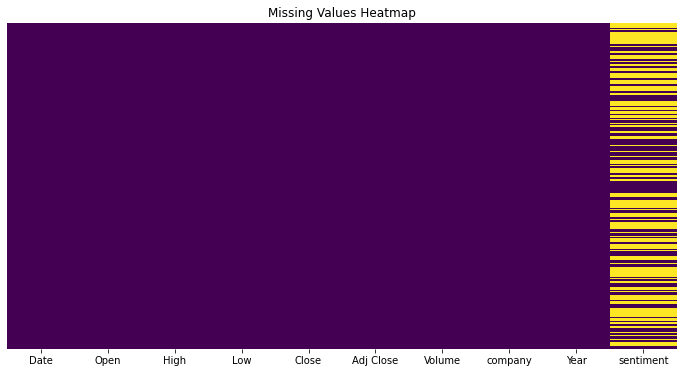

In [98]:
# visualisingmissing values

plt.figure(figsize=(12, 6))
sns.heatmap(final_meta.isna(), cbar=False, cmap="viridis", yticklabels=False)
plt.title("Missing Values Heatmap")
plt.show()


# 1. KNN-Based Mean Imputation (Univariate)
First imputation method is a custom KNN-style mean imputation. For each missing value in the sentiment time series, the function calculates the mean of the n nearest known past and future values (excluding the missing value itself). This method is univariate, relying solely on the sentiment column.

Pros: Simple and leverages local temporal context.

Cons: Ignores other potentially informative features.

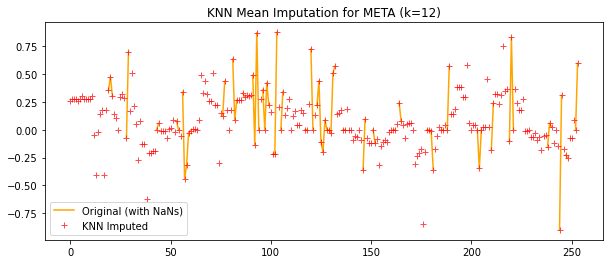

In [99]:
# Function to impute missing values using mean of n nearest past/future neighbors
def knn_mean(ts, n):
    out = np.copy(ts)
    for i, val in enumerate(ts):
        if np.isnan(val):
            n_by_2 = np.ceil(n / 2)
            lower = np.max([0, int(i - n_by_2)])
            upper = np.min([len(ts), int(i + n_by_2)])
            ts_near = np.concatenate([ts[lower:i], ts[i+1:upper]])  # skip current index
            out[i] = np.nanmean(ts_near)
    return out

# Apply the KNN mean imputation
final_meta['knn_mean'] = knn_mean(final_meta['sentiment'].values, 12)

# Plot
fig, ax = plt.subplots(figsize=(10, 4))
final_meta['sentiment'].plot(ax=ax, label='Original (with NaNs)', style='-', color='orange')
final_meta['knn_mean'].plot(ax=ax, label='KNN Imputed', style='+', color='red', alpha=0.7)
ax.set_title("KNN Mean Imputation for META (k=12)")
ax.legend()
plt.show()


In [100]:
final_meta['knn_mean'].isna().sum()

0

# 2. Multivariate KNN Imputation

Using sklearn's KNNImputer, a multivariate imputation method that utilizes additional features like Close and Volume was applied . 
This method considers the similarity of entire data points (rows) when imputing missing values.

Pros: Takes into account correlations with other variables.

Cons: May be sensitive to feature scaling or irrelevant features.

In [101]:
# importing imputer 
from sklearn.impute import KNNImputer

# Select features to use for imputation
features = ['sentiment', 'Close', 'Volume']
imputer = KNNImputer(n_neighbors=5)

# Fit and transform
imputed_array = imputer.fit_transform(final_meta[features])

# Replace original 'sentiment' with imputed one
final_meta['knn_imputer'] = imputed_array[:, 0]


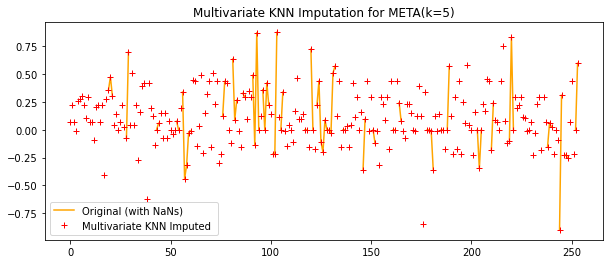

In [102]:
# visualise imputation 
fig, ax = plt.subplots(figsize=(10, 4))
final_meta['sentiment'].plot(ax=ax, label='Original (with NaNs)', style='-', color='orange')
final_meta['knn_imputer'].plot(ax=ax, label='Multivariate KNN Imputed ', style='+', color='red')
ax.set_title("Multivariate KNN Imputation for META(k=5)")
ax.legend()
plt.show()


# 3. Impute missing values based on Close percent Change 
To impute missing sentiment values, the percentage change in the Close price is first calculated and scaled to a range of -1 to +1 using the tanh function. For rows with missing sentiment, the scaled percentage change is used to fill in the missing values. Any remaining NaN values in the sentiment_imputed column are backfilled with the next available value, ensuring that all missing sentiment values are properly imputed. Finally, the relevant columns (Close, Close_pct_change, sentiment, sentiment_imputed) are displayed for review.

In [103]:
# 1. Calculate percentage change in Close
final_meta['Close_pct_change'] = final_meta['Close'].pct_change()


# 1. Scale Close_pct_change to [-1, +1]
final_meta['Close_pct_change'] = np.tanh(final_meta['Close_pct_change'])

# 2. Create a new column for sentiment imputation, preserving original sentiment
final_meta['sentiment_imputed'] = final_meta['sentiment']

# 3. For missing sentiment values, replace with Close_pct_change
final_meta.loc[final_meta['sentiment'].isna(), 'sentiment_imputed'] = final_meta.loc[final_meta['sentiment'].isna(), 'Close_pct_change']

# 4. Fill remaining missing values (if any) using backfill
final_meta['sentiment_imputed'] = final_meta['sentiment_imputed'].bfill()

# 5. Display relevant columns
final_meta[['Close', 'Close_pct_change', 'sentiment', 'sentiment_imputed']]


,Close,Close_pct_change,sentiment,sentiment_imputed
0,205.250000,NaN,NaN,0.022067
1,209.779999,0.022067,NaN,0.022067
2,208.669998,-0.005291,NaN,-0.005291
3,212.600006,0.018831,NaN,0.018831
4,213.059998,0.002164,0.2583,0.258300
...,...,...,...,...
249,267.399994,-0.002648,NaN,-0.002648
250,277.000000,0.035886,NaN,0.035886
251,276.779999,-0.000794,NaN,-0.000794
252,271.869995,-0.017738,0.0000,0.000000


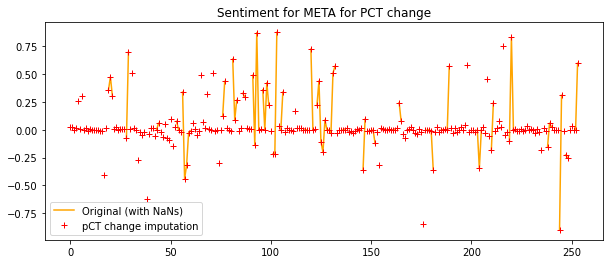

In [104]:
# Displaying results
fig, ax = plt.subplots(figsize=(10, 4))
final_meta['sentiment'].plot(ax=ax, label='Original (with NaNs)', style='-', color='orange')
final_meta['sentiment_imputed'].plot(ax=ax, label='pCT change imputation', style='+', color='red')
ax.set_title("Sentiment for META for PCT change")
ax.legend()
plt.show()

# 4. Linear Interpolation (Polynomial Order 1)
Finally, linear interpolation was used , which estimates missing values by fitting a straight line between known points. This is equivalent to a polynomial interpolation of order 1.

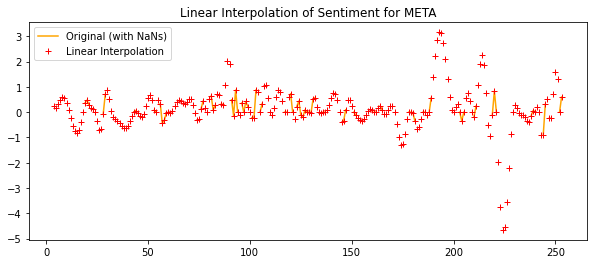

In [105]:
# Polynomial of degree 1 == linear, just for comparison
final_meta['sentiment_poly'] = final_meta['sentiment'].interpolate(method='polynomial', order=5)


fig, ax = plt.subplots(figsize=(10, 4))
final_meta['sentiment'].plot(ax=ax, label='Original (with NaNs)', style='-', color='orange')
final_meta['sentiment_poly'].plot(ax=ax, label='Linear Interpolation', style='+', color='red')
ax.set_title("Linear Interpolation of Sentiment for META")
ax.legend()
plt.show()


In [106]:
#saving the final df and visualising the data 

final_meta.to_csv('final_meta.csv', index=False)

final_meta.head()



,Date,Open,High,Low,Close,Adj Close,Volume,company,Year,sentiment,knn_mean,knn_imputer,Close_pct_change,sentiment_imputed,sentiment_poly
0,2019-12-31,204.000000,205.559998,203.600006,205.250000,205.250000,8953500,META,2019,NaN,0.258300,0.066540,NaN,0.022067,NaN
1,2020-01-02,206.750000,209.789993,206.270004,209.779999,209.779999,12077100,META,2020,NaN,0.280875,0.227010,0.022067,0.022067,NaN
2,2020-01-03,207.210007,210.399994,206.949997,208.669998,208.669998,11188400,META,2020,NaN,0.280875,0.066540,-0.005291,-0.005291,NaN
3,2020-01-06,206.699997,212.779999,206.520004,212.600006,212.600006,17058900,META,2020,NaN,0.280875,-0.010555,0.018831,0.018831,NaN
4,2020-01-07,212.820007,214.580002,211.750000,213.059998,213.059998,14912400,META,2020,0.2583,0.258300,0.258300,0.002164,0.258300,0.2583


# Creating final Amazon DF 

In [107]:
pandas_amzn.head()

,Date,Open,High,Low,Close,Adj Close,Volume,company,Year
0,2019-12-31,92.099998,92.663002,91.611504,92.391998,92.391998,50130000,AMZN,2019
1,2020-01-02,93.750000,94.900497,93.207497,94.900497,94.900497,80580000,AMZN,2020
2,2020-01-03,93.224998,94.309998,93.224998,93.748497,93.748497,75288000,AMZN,2020
3,2020-01-06,93.000000,95.184502,93.000000,95.143997,95.143997,81236000,AMZN,2020
4,2020-01-07,95.224998,95.694504,94.601997,95.343002,95.343002,80898000,AMZN,2020


In [108]:
print(amzn_tweets.shape)
amzn_tweets.head()

(407, 7)


,id,date,ticker,tweet,company,clean_tweet,sentiment
0,100001,2020-01-01,AMZN,$AMZN Dow futures up by 100 points already 🥳,stocktweet,dow futures up by points already,0.0000
21,100022,2020-01-03,AMZN,$AMZN who ever shorted today will be deported ...,stocktweet,who ever shorted today will be deported from u...,0.0000
29,100030,2020-01-06,AMZN,$AMZN I hope we can come close to touching 200...,stocktweet,i hope we can come close to touching either t...,0.4404
52,100053,2020-01-07,AMZN,$AMZN CONGRATS TO ALL THE LONG - there were so...,stocktweet,congrats to all the long there were some tryi...,0.7579
95,100096,2020-01-09,AMZN,$AMZN Now it’s moving with the market 😂,stocktweet,now its moving with the market,0.0000


In [109]:
# Aggregating values to get the average sentiment for that day 

amzn_tweets = amzn_tweets.groupby('date').agg({
    'sentiment': 'mean',  # calculating the mean for that day 
}).reset_index()

In [110]:
#Creating the final df
final_amzn = pd.merge(pandas_amzn, amzn_tweets, how='left', left_on='Date', right_on='date')
final_amzn.columns
final_amzn.drop('date',axis =1, inplace = True)


In [111]:
final_amzn.head()

,Date,Open,High,Low,Close,Adj Close,Volume,company,Year,sentiment
0,2019-12-31,92.099998,92.663002,91.611504,92.391998,92.391998,50130000,AMZN,2019,NaN
1,2020-01-02,93.750000,94.900497,93.207497,94.900497,94.900497,80580000,AMZN,2020,NaN
2,2020-01-03,93.224998,94.309998,93.224998,93.748497,93.748497,75288000,AMZN,2020,0.0000
3,2020-01-06,93.000000,95.184502,93.000000,95.143997,95.143997,81236000,AMZN,2020,0.4404
4,2020-01-07,95.224998,95.694504,94.601997,95.343002,95.343002,80898000,AMZN,2020,0.7579


In [112]:
final_amzn['sentiment'].isna().sum()

87

In [113]:
final_amzn['Close'].isna().sum()
print(final_amzn.shape)

(254, 10)


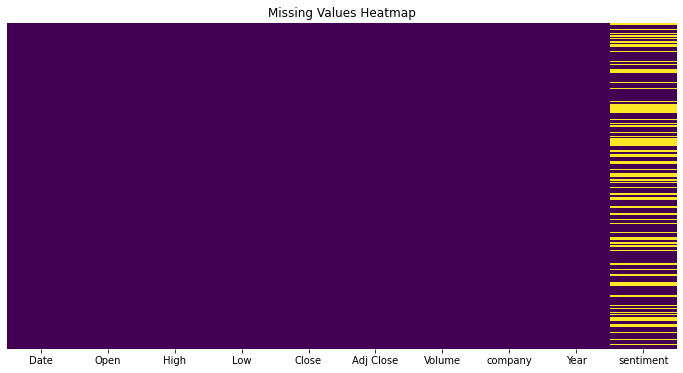

In [114]:
# visualising missing values

plt.figure(figsize=(12, 6))
sns.heatmap(final_amzn.isna(), cbar=False, cmap="viridis", yticklabels=False)
plt.title("Missing Values Heatmap")
plt.show()


# 1. KNN-Based Mean Imputation (Univariate)
First imputation method is a custom KNN-style mean imputation. For each missing value in the sentiment time series, the function calculates the mean of the n nearest known past and future values (excluding the missing value itself). This method is univariate, relying solely on the sentiment column.

Pros: Simple and leverages local temporal context.

Cons: Ignores other potentially informative features.

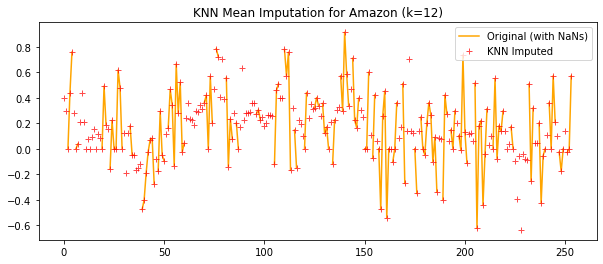

In [115]:
# Function to impute missing values using mean of n nearest past/future neighbors
def knn_mean(ts, n):
    out = np.copy(ts)
    for i, val in enumerate(ts):
        if np.isnan(val):
            n_by_2 = np.ceil(n / 2)
            lower = np.max([0, int(i - n_by_2)])
            upper = np.min([len(ts), int(i + n_by_2)])
            ts_near = np.concatenate([ts[lower:i], ts[i+1:upper]])  # skip current index
            out[i] = np.nanmean(ts_near)
    return out

# Apply the KNN mean imputation
final_amzn['knn_mean'] = knn_mean(final_amzn['sentiment'].values, 12)

# Plot
fig, ax = plt.subplots(figsize=(10, 4))
final_amzn['sentiment'].plot(ax=ax, label='Original (with NaNs)', style='-', color='orange')
final_amzn['knn_mean'].plot(ax=ax, label='KNN Imputed', style='+', color='red', alpha=0.7)
ax.set_title("KNN Mean Imputation for Amazon (k=12)")
ax.legend()
plt.show()


# 2. Multivariate KNN Imputation

Using sklearn's KNNImputer, a multivariate imputation method that utilizes additional features like Close and Volume was applied . 
This method considers the similarity of entire data points (rows) when imputing missing values.

Pros: Takes into account correlations with other variables.

Cons: May be sensitive to feature scaling or irrelevant features.

In [116]:
# importing imputer 
from sklearn.impute import KNNImputer

# Select features to use for imputation
features = ['sentiment', 'Close', 'Volume']
imputer = KNNImputer(n_neighbors=5)

# Fit and transform
imputed_array = imputer.fit_transform(final_amzn[features])

# Replace original 'sentiment' with imputed one
final_amzn['knn_imputer'] = imputed_array[:, 0]

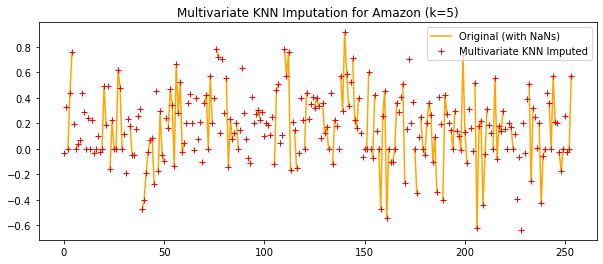

In [117]:
# visualise imputation 
fig, ax = plt.subplots(figsize=(10, 4))
final_amzn['sentiment'].plot(ax=ax, label='Original (with NaNs)', style='-', color='orange')
final_amzn['knn_imputer'].plot(ax=ax, label='Multivariate KNN Imputed', style='+', color='red')
ax.set_title("Multivariate KNN Imputation for Amazon (k=5)")
ax.legend()
plt.show()

# 3. Impute missing values based on Close percent Change 
To impute missing sentiment values, the percentage change in the Close price is first calculated and scaled to a range of -1 to +1 using the tanh function. For rows with missing sentiment, the scaled percentage change is used to fill in the missing values. Any remaining NaN values in the sentiment_imputed column are backfilled with the next available value, ensuring that all missing sentiment values are properly imputed. Finally, the relevant columns (Close, Close_pct_change, sentiment, sentiment_imputed) are displayed for review.

In [118]:
# 1. Calculate percentage change in Close
final_amzn['Close_pct_change'] = final_amzn['Close'].pct_change()


# 2. Scale Close_pct_change to [-1, +1]
final_amzn['Close_pct_change'] = np.tanh(final_amzn['Close_pct_change'])

# 3. Create a new column for sentiment imputation, preserving original sentiment
final_amzn['sentiment_imputed'] = final_amzn['sentiment']

# 4. For missing sentiment values, replace with Close_pct_change
final_amzn.loc[final_amzn['sentiment'].isna(), 'sentiment_imputed'] = final_amzn.loc[final_amzn['sentiment'].isna(), 'Close_pct_change']

# 5. Fill remaining missing values (if any) using backfill
final_amzn['sentiment_imputed'] = final_amzn['sentiment_imputed'].bfill()

# 6. Display relevant columns
final_amzn[['Close', 'Close_pct_change', 'sentiment', 'sentiment_imputed']]


,Close,Close_pct_change,sentiment,sentiment_imputed
0,92.391998,NaN,NaN,0.027144
1,94.900497,0.027144,NaN,0.027144
2,93.748497,-0.012138,0.00000,0.000000
3,95.143997,0.014884,0.44040,0.440400
4,95.343002,0.002092,0.75790,0.757900
...,...,...,...,...
249,158.634506,-0.003949,0.00000,0.000000
250,164.197998,0.035057,NaN,0.035057
251,166.100006,0.011583,-0.02955,-0.029550
252,164.292496,-0.010882,0.00000,0.000000


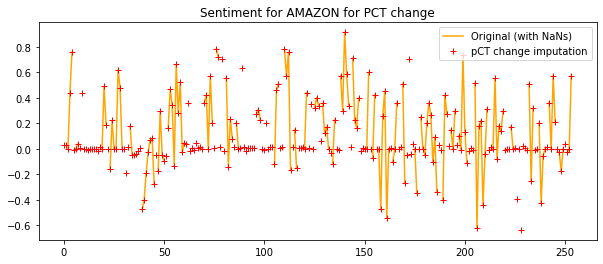

In [119]:
# Displaying results
fig, ax = plt.subplots(figsize=(10, 4))
final_amzn['sentiment'].plot(ax=ax, label='Original (with NaNs)', style='-', color='orange')
final_amzn['sentiment_imputed'].plot(ax=ax, label='pCT change imputation', style='+', color='red')
ax.set_title("Sentiment for AMAZON for PCT change")
ax.legend()
plt.show()

# 4. Linear Interpolation (Polynomial Order 1)
Finally, linear interpolation was used , which estimates missing values by fitting a straight line between known points. This is equivalent to a polynomial interpolation of order 1.

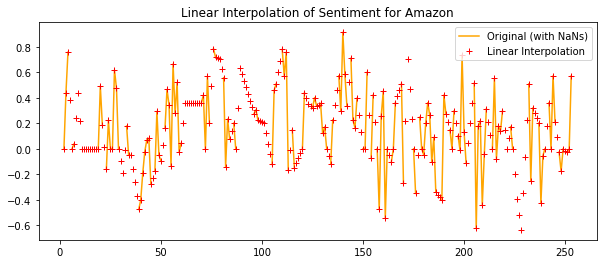

In [120]:
# Polynomial of degree 1 == linear, just for comparison
final_amzn['sentiment_poly'] = final_amzn['sentiment'].interpolate(method='polynomial', order=1)


fig, ax = plt.subplots(figsize=(10, 4))
final_amzn['sentiment'].plot(ax=ax, label='Original (with NaNs)', style='-', color='orange')
final_amzn['sentiment_poly'].plot(ax=ax, label='Linear Interpolation', style='+', color='red')
ax.set_title("Linear Interpolation of Sentiment for Amazon")
ax.legend()
plt.show()


In [121]:
#saving the final df and visualising the data 

final_amzn.to_csv('final_amzn.csv', index=False)

final_amzn.head()



,Date,Open,High,Low,Close,Adj Close,Volume,company,Year,sentiment,knn_mean,knn_imputer,Close_pct_change,sentiment_imputed,sentiment_poly
0,2019-12-31,92.099998,92.663002,91.611504,92.391998,92.391998,50130000,AMZN,2019,NaN,0.399433,-0.032413,NaN,0.027144,NaN
1,2020-01-02,93.750000,94.900497,93.207497,94.900497,94.900497,80580000,AMZN,2020,NaN,0.299575,0.329290,0.027144,0.027144,NaN
2,2020-01-03,93.224998,94.309998,93.224998,93.748497,93.748497,75288000,AMZN,2020,0.0000,0.000000,0.000000,-0.012138,0.000000,0.0000
3,2020-01-06,93.000000,95.184502,93.000000,95.143997,95.143997,81236000,AMZN,2020,0.4404,0.440400,0.440400,0.014884,0.440400,0.4404
4,2020-01-07,95.224998,95.694504,94.601997,95.343002,95.343002,80898000,AMZN,2020,0.7579,0.757900,0.757900,0.002092,0.757900,0.7579


# Creating final APPLE DF 

In [122]:
pandas_aapl.head()

,Date,Open,High,Low,Close,Adj Close,Volume,company,Year
0,2019-12-31,72.482498,73.419998,72.379997,73.412498,71.520821,100805600,AAPL,2019
1,2020-01-02,74.059998,75.150002,73.797501,75.087502,73.152649,135480400,AAPL,2020
2,2020-01-03,74.287498,75.144997,74.125000,74.357498,72.441460,146322800,AAPL,2020
3,2020-01-06,73.447502,74.989998,73.187500,74.949997,73.018677,118387200,AAPL,2020
4,2020-01-07,74.959999,75.224998,74.370003,74.597504,72.675278,108872000,AAPL,2020


In [123]:
print(aapl_tweets.shape)
aapl_tweets.head()

(1721, 7)


,id,date,ticker,tweet,company,clean_tweet,sentiment
2,100003,2020-01-01,AAPL,$AAPL We’ll been riding since last December fr...,stocktweet,well been riding since last december from wha...,0.2732
6,100007,2020-01-02,AAPL,$AAPL $300 calls First trade of 2020 Congrats ...,stocktweet,calls first trade of congrats to all bulls,0.5267
7,100008,2020-01-02,AAPL,"$AAPL Remember, if you short every day, one of...",stocktweet,remember if you short every day one of those d...,0.0000
8,100009,2020-01-02,AAPL,"$AAPL called it, the bear comment below makes ...",stocktweet,called it the bear comment below makes me chuc...,0.4019
10,100011,2020-01-02,AAPL,Apple is taking things UP in 2020 🚀🚀 $AAPL,stocktweet,apple is taking things up in,0.0000


In [124]:
# Aggregating values to get the average sentiment for that day 

aapl_tweets = aapl_tweets.groupby('date').agg({
    'sentiment': 'mean',  # calculating the mean for that day 
}).reset_index()

In [125]:
#Creating the final df
final_aapl = pd.merge(pandas_aapl, aapl_tweets, how='left', left_on='Date', right_on='date')
final_aapl.columns
final_aapl.drop('date',axis =1, inplace = True)


In [126]:
final_aapl.head()

,Date,Open,High,Low,Close,Adj Close,Volume,company,Year,sentiment
0,2019-12-31,72.482498,73.419998,72.379997,73.412498,71.520821,100805600,AAPL,2019,NaN
1,2020-01-02,74.059998,75.150002,73.797501,75.087502,73.152649,135480400,AAPL,2020,0.376125
2,2020-01-03,74.287498,75.144997,74.125000,74.357498,72.441460,146322800,AAPL,2020,0.103833
3,2020-01-06,73.447502,74.989998,73.187500,74.949997,73.018677,118387200,AAPL,2020,0.779300
4,2020-01-07,74.959999,75.224998,74.370003,74.597504,72.675278,108872000,AAPL,2020,0.069367


In [127]:
final_aapl['sentiment'].isna().sum()

22

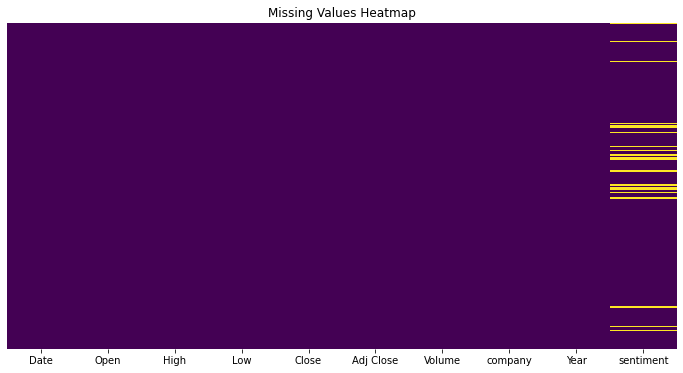

In [128]:
# visualisingmissing values

plt.figure(figsize=(12, 6))
sns.heatmap(final_aapl.isna(), cbar=False, cmap="viridis", yticklabels=False)
plt.title("Missing Values Heatmap")
plt.show()


In [129]:
final_aapl.shape

(254, 10)

# 1. KNN-Based Mean Imputation (Univariate)
First imputation method is a custom KNN-style mean imputation. For each missing value in the sentiment time series, the function calculates the mean of the n nearest known past and future values (excluding the missing value itself). This method is univariate, relying solely on the sentiment column.

Pros: Simple and leverages local temporal context.

Cons: Ignores other potentially informative features.

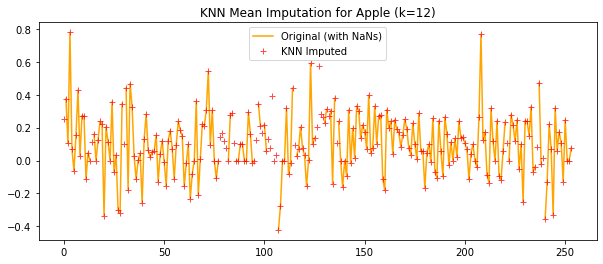

In [130]:
# Function to impute missing values using mean of n nearest past/future neighbors
def knn_mean(ts, n):
    out = np.copy(ts)
    for i, val in enumerate(ts):
        if np.isnan(val):
            n_by_2 = np.ceil(n / 2)
            lower = np.max([0, int(i - n_by_2)])
            upper = np.min([len(ts), int(i + n_by_2)])
            ts_near = np.concatenate([ts[lower:i], ts[i+1:upper]])  # skip current index
            out[i] = np.nanmean(ts_near)
    return out

# Apply the KNN mean imputation
final_aapl['knn_mean'] = knn_mean(final_aapl['sentiment'].values, 12)

# Plot
fig, ax = plt.subplots(figsize=(10, 4))
final_aapl['sentiment'].plot(ax=ax, label='Original (with NaNs)', style='-', color='orange')
final_aapl['knn_mean'].plot(ax=ax, label='KNN Imputed', style='+', color='red', alpha=0.7)
ax.set_title("KNN Mean Imputation for Apple (k=12)")
ax.legend()
plt.show()




# 2. Multivariate KNN Imputation

Using sklearn's KNNImputer, a multivariate imputation method that utilizes additional features like Close and Volume was applied . 
This method considers the similarity of entire data points (rows) when imputing missing values.

Pros: Takes into account correlations with other variables.

Cons: May be sensitive to feature scaling or irrelevant features.

In [131]:
# importing imputer 
from sklearn.impute import KNNImputer

# Select features to use for imputation
features = ['sentiment', 'Close', 'Volume']
imputer = KNNImputer(n_neighbors=5)

# Fit and transform
imputed_array = imputer.fit_transform(final_aapl[features])

# Replace original 'sentiment' with imputed one
final_aapl['knn_imputer'] = imputed_array[:, 0]

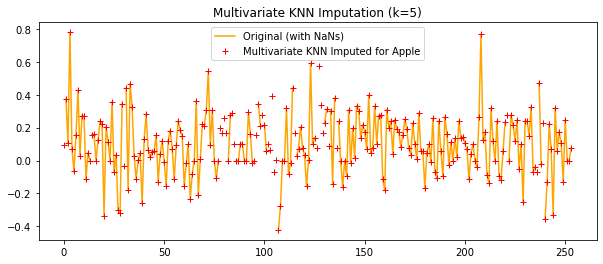

In [132]:
# visualise imputation 
fig, ax = plt.subplots(figsize=(10, 4))
final_aapl['sentiment'].plot(ax=ax, label='Original (with NaNs)', style='-', color='orange')
final_aapl['knn_imputer'].plot(ax=ax, label='Multivariate KNN Imputed for Apple', style='+', color='red')
ax.set_title("Multivariate KNN Imputation (k=5)")
ax.legend()
plt.show()

# 3. Impute missing values based on Close percent Change
To impute missing sentiment values, the percentage change in the Close price is first calculated and scaled to a range of -1 to +1 using the tanh function. For rows with missing sentiment, the scaled percentage change is used to fill in the missing values. Any remaining NaN values in the sentiment_imputed column are backfilled with the next available value, ensuring that all missing sentiment values are properly imputed. Finally, the relevant columns (Close, Close_pct_change, sentiment, sentiment_imputed) are displayed for review.

In [133]:
# 1. Calculate percentage change in Close
final_aapl['Close_pct_change'] = final_aapl['Close'].pct_change()


# 2. Scale Close_pct_change to [-1, +1]
final_aapl['Close_pct_change'] = np.tanh(final_aapl['Close_pct_change'])

# 3. Create a new column for sentiment imputation, preserving original sentiment
final_aapl['sentiment_imputed'] = final_aapl['sentiment']

# 4. For missing sentiment values, replace with Close_pct_change
final_aapl.loc[final_aapl['sentiment'].isna(), 'sentiment_imputed'] = final_aapl.loc[final_aapl['sentiment'].isna(), 'Close_pct_change']

# 5. Fill remaining missing values (if any) using backfill
final_aapl['sentiment_imputed'] = final_aapl['sentiment_imputed'].bfill()

# 6. Display relevant columns
final_aapl[['Close', 'Close_pct_change', 'sentiment', 'sentiment_imputed']]



,Close,Close_pct_change,sentiment,sentiment_imputed
0,73.412498,NaN,NaN,0.376125
1,75.087502,0.022812,0.376125,0.376125
2,74.357498,-0.009722,0.103833,0.103833
3,74.949997,0.007968,0.779300,0.779300
4,74.597504,-0.004703,0.069367,0.069367
...,...,...,...,...
249,131.970001,0.007712,-0.128000,-0.128000
250,136.690002,0.035750,0.246350,0.246350
251,134.869995,-0.013314,0.000000,0.000000
252,133.720001,-0.008526,0.000000,0.000000


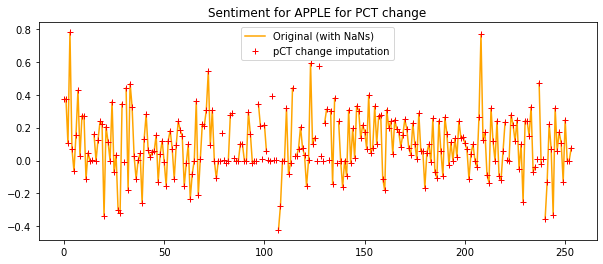

In [134]:
# Displaying results
fig, ax = plt.subplots(figsize=(10, 4))
final_aapl['sentiment'].plot(ax=ax, label='Original (with NaNs)', style='-', color='orange')
final_aapl['sentiment_imputed'].plot(ax=ax, label='pCT change imputation', style='+', color='red')
ax.set_title("Sentiment for APPLE for PCT change")
ax.legend()
plt.show()

# 4. Linear Interpolation (Polynomial Order 1)
Finally, linear interpolation was used , which estimates missing values by fitting a straight line between known points. This is equivalent to a polynomial interpolation of order 1.

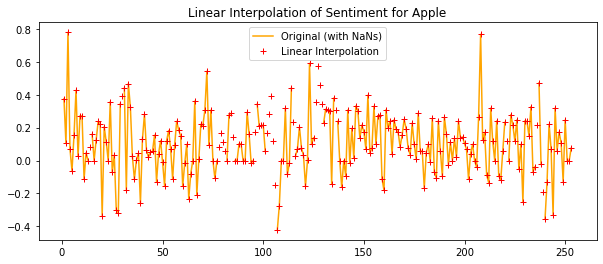

In [135]:
# Polynomial of degree 1 == linear, just for comparison
final_aapl['sentiment_poly'] = final_aapl['sentiment'].interpolate(method='polynomial', order=1)


fig, ax = plt.subplots(figsize=(10, 4))
final_aapl['sentiment'].plot(ax=ax, label='Original (with NaNs)', style='-', color='orange')
final_aapl['sentiment_poly'].plot(ax=ax, label='Linear Interpolation', style='+', color='red')
ax.set_title("Linear Interpolation of Sentiment for Apple")
ax.legend()
plt.show()


In [136]:
#saving the final df and visualising the data 

final_aapl.to_csv('final_aapl.csv', index=False)

final_aapl.head()


,Date,Open,High,Low,Close,Adj Close,Volume,company,Year,sentiment,knn_mean,knn_imputer,Close_pct_change,sentiment_imputed,sentiment_poly
0,2019-12-31,72.482498,73.419998,72.379997,73.412498,71.520821,100805600,AAPL,2019,NaN,0.253212,0.095975,NaN,0.376125,NaN
1,2020-01-02,74.059998,75.150002,73.797501,75.087502,73.152649,135480400,AAPL,2020,0.376125,0.376125,0.376125,0.022812,0.376125,0.376125
2,2020-01-03,74.287498,75.144997,74.125000,74.357498,72.441460,146322800,AAPL,2020,0.103833,0.103833,0.103833,-0.009722,0.103833,0.103833
3,2020-01-06,73.447502,74.989998,73.187500,74.949997,73.018677,118387200,AAPL,2020,0.779300,0.779300,0.779300,0.007968,0.779300,0.779300
4,2020-01-07,74.959999,75.224998,74.370003,74.597504,72.675278,108872000,AAPL,2020,0.069367,0.069367,0.069367,-0.004703,0.069367,0.069367


# Creating final Netflix DF 

In [137]:
pandas_nflx

,Date,Open,High,Low,Close,Adj Close,Volume,company,Year
0,2019-12-31,322.000000,324.920013,321.089996,323.570007,323.570007,3713300,NFLX,2019
1,2020-01-02,326.100006,329.980011,324.779999,329.809998,329.809998,4485800,NFLX,2020
2,2020-01-03,326.779999,329.859985,325.529999,325.899994,325.899994,3806900,NFLX,2020
3,2020-01-06,323.119995,336.359985,321.200012,335.829987,335.829987,5663100,NFLX,2020
4,2020-01-07,336.470001,336.700012,330.299988,330.750000,330.750000,4703200,NFLX,2020
...,...,...,...,...,...,...,...,...,...
249,2020-12-24,515.119995,519.349976,512.210022,513.969971,513.969971,1144000,NFLX,2020
250,2020-12-28,516.429993,523.659973,507.130005,519.119995,519.119995,2891900,NFLX,2020
251,2020-12-29,519.900024,536.549988,515.479980,530.869995,530.869995,4022400,NFLX,2020
252,2020-12-30,530.130005,533.260010,523.690002,524.590027,524.590027,1876300,NFLX,2020


In [138]:
print(nflx_tweets.shape)
nflx_tweets.head()

(195, 7)


,id,date,ticker,tweet,company,clean_tweet,sentiment
31,100032,2020-01-06,NFLX,$NFLX 🔥🔥🔥✈️ 336 test to possibly test 340s tom...,stocktweet,test to possibly test s tomorrow all day ment...,0.0000
117,100118,2020-01-10,NFLX,$NFLX Morningstar’s fair value estimate is $135 😳,stocktweet,morningstars fair value estimate is,0.5719
236,100237,2020-01-18,NFLX,"$NFLX 💵 booked a week earlier, ER scares me",stocktweet,booked a week earlier er scares me,-0.3400
253,100254,2020-01-22,NFLX,$NFLX love when they lie to kill shorts so the...,stocktweet,love when they lie to kill shorts so they can ...,-0.1280
277,100278,2020-01-22,NFLX,"$NFLX sooo if 360 doesn't work, let's live to...",stocktweet,sooo if doesnt work lets live to trade anothe...,0.0000


In [139]:
nflx_tweets = nflx_tweets.groupby('date').agg({
    'sentiment': 'mean',  # calculating the mean for that day 
}).reset_index()

In [140]:
#Creating the final df
final_nflx = pd.merge(pandas_nflx, nflx_tweets, how='left', left_on='Date', right_on='date')
final_nflx.columns


Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
       'company', 'Year', 'date', 'sentiment'],
      dtype='object')

In [141]:
final_nflx.head()
final_nflx.shape

(254, 11)

In [142]:
final_nflx['sentiment'].isna().sum()

161

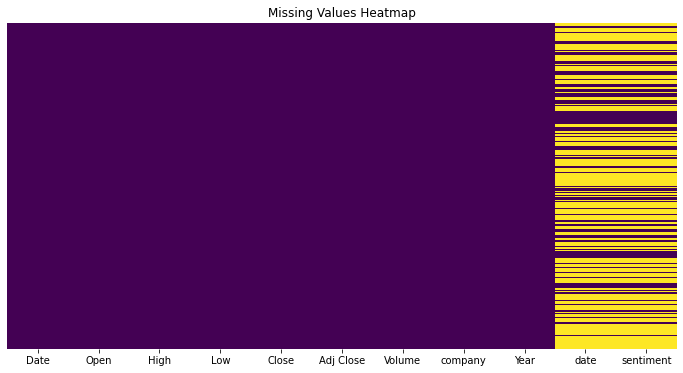

In [143]:
# visualisingmissing values

plt.figure(figsize=(12, 6))
sns.heatmap(final_nflx.isna(), cbar=False, cmap="viridis", yticklabels=False)
plt.title("Missing Values Heatmap")
plt.show()


In [144]:
final_nflx.shape

(254, 11)

# 1. KNN-Based Mean Imputation (Univariate)
First imputation method is a custom KNN-style mean imputation. For each missing value in the sentiment time series, the function calculates the mean of the n nearest known past and future values (excluding the missing value itself). This method is univariate, relying solely on the sentiment column.

Pros: Simple and leverages local temporal context.

Cons: Ignores other potentially informative features.

/tmp/ipykernel_7608/2149632361.py:10: RuntimeWarning: Mean of empty slice
  out[i] = np.nanmean(ts_near)


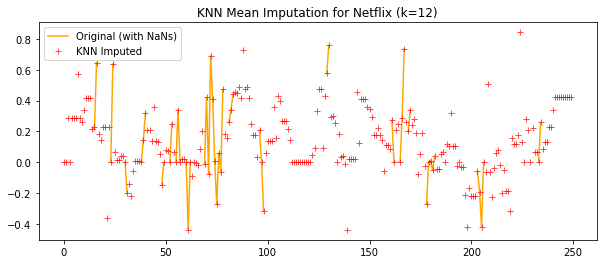

In [145]:
# Function to impute missing values using mean of n nearest past/future neighbors
def knn_mean(ts, n):
    out = np.copy(ts)
    for i, val in enumerate(ts):
        if np.isnan(val):
            n_by_2 = np.ceil(n / 2)
            lower = np.max([0, int(i - n_by_2)])
            upper = np.min([len(ts), int(i + n_by_2)])
            ts_near = np.concatenate([ts[lower:i], ts[i+1:upper]])  # skip current index
            out[i] = np.nanmean(ts_near)
    return out

# Apply the KNN mean imputation
final_nflx['knn_mean'] = knn_mean(final_nflx['sentiment'].values, 12)

# Plot
fig, ax = plt.subplots(figsize=(10, 4))
final_nflx['sentiment'].plot(ax=ax, label='Original (with NaNs)', style='-', color='orange')
final_nflx['knn_mean'].plot(ax=ax, label='KNN Imputed', style='+', color='red', alpha=0.7)
ax.set_title("KNN Mean Imputation for Netflix (k=12)")
ax.legend()
plt.show()



# 2. Multivariate KNN Imputation

Using sklearn's KNNImputer, a multivariate imputation method that utilizes additional features like Close and Volume was applied . 
This method considers the similarity of entire data points (rows) when imputing missing values.

Pros: Takes into account correlations with other variables.

Cons: May be sensitive to feature scaling or irrelevant features.

In [146]:
# importing imputer 
from sklearn.impute import KNNImputer

# Select features to use for imputation
features = ['sentiment', 'Close', 'Volume']
imputer = KNNImputer(n_neighbors=5)

# Fit and transform
imputed_array = imputer.fit_transform(final_aapl[features])

# Replace original 'sentiment' with imputed one
final_nflx['knn_imputer'] = imputed_array[:, 0]

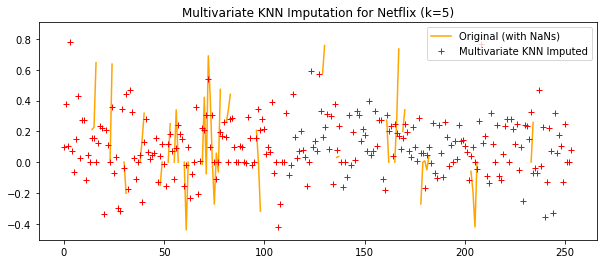

In [147]:
# visualise imputation 
fig, ax = plt.subplots(figsize=(10, 4))
final_nflx['sentiment'].plot(ax=ax, label='Original (with NaNs)', style='-', color='orange')
final_nflx['knn_imputer'].plot(ax=ax, label='Multivariate KNN Imputed', style='+', color='red')
ax.set_title("Multivariate KNN Imputation for Netflix (k=5)")
ax.legend()
plt.show()

# 3. Impute missing values based on Close percent Change
To impute missing sentiment values, the percentage change in the Close price is first calculated and scaled to a range of -1 to +1 using the tanh function. For rows with missing sentiment, the scaled percentage change is used to fill in the missing values. Any remaining NaN values in the sentiment_imputed column are backfilled with the next available value, ensuring that all missing sentiment values are properly imputed. Finally, the relevant columns (Close, Close_pct_change, sentiment, sentiment_imputed) are displayed for review.

In [148]:
# 1. Calculate percentage change in Close
final_nflx['Close_pct_change'] = final_nflx['Close'].pct_change()


# 2. Scale Close_pct_change to [-1, +1]
final_nflx['Close_pct_change'] = np.tanh(final_nflx['Close_pct_change'])

# 3. Create a new column for sentiment imputation, preserving original sentiment
final_nflx['sentiment_imputed'] = final_nflx['sentiment']

# 4. For missing sentiment values, replace with Close_pct_change
final_nflx.loc[final_nflx['sentiment'].isna(), 'sentiment_imputed'] = final_nflx.loc[final_nflx['sentiment'].isna(), 'Close_pct_change']

# 5. Fill remaining missing values (if any) using backfill
final_nflx['sentiment_imputed'] = final_nflx['sentiment_imputed'].bfill()

# 6. Display relevant columns
final_nflx[['Close', 'Close_pct_change', 'sentiment', 'sentiment_imputed']]



,Close,Close_pct_change,sentiment,sentiment_imputed
0,323.570007,NaN,NaN,0.019282
1,329.809998,0.019282,NaN,0.019282
2,325.899994,-0.011855,NaN,-0.011855
3,335.829987,0.030460,0.0,0.000000
4,330.750000,-0.015126,NaN,-0.015126
...,...,...,...,...
249,513.969971,-0.000991,NaN,-0.000991
250,519.119995,0.010020,NaN,0.010020
251,530.869995,0.022631,NaN,0.022631
252,524.590027,-0.011829,NaN,-0.011829


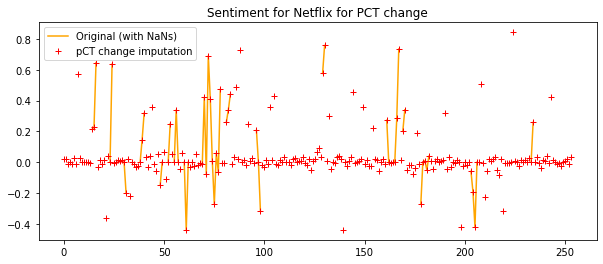

In [149]:
# Displaying results
fig, ax = plt.subplots(figsize=(10, 4))
final_nflx['sentiment'].plot(ax=ax, label='Original (with NaNs)', style='-', color='orange')
final_nflx['sentiment_imputed'].plot(ax=ax, label='pCT change imputation', style='+', color='red')
ax.set_title("Sentiment for Netflix for PCT change")
ax.legend()
plt.show()

# 4. Linear Interpolation (Polynomial Order 1)
Finally, linear interpolation was used , which estimates missing values by fitting a straight line between known points. This is equivalent to a polynomial interpolation of order 1.

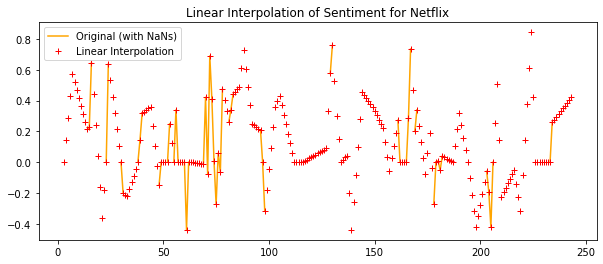

In [150]:
# Polynomial of degree 1 == linear, just for comparison
final_nflx['sentiment_poly'] = final_nflx['sentiment'].interpolate(method='polynomial', order=1)


fig, ax = plt.subplots(figsize=(10, 4))
final_nflx['sentiment'].plot(ax=ax, label='Original (with NaNs)', style='-', color='orange')
final_nflx['sentiment_poly'].plot(ax=ax, label='Linear Interpolation', style='+', color='red')
ax.set_title("Linear Interpolation of Sentiment for Netflix")
ax.legend()
plt.show()


In [151]:
#saving the final df and visualising the data 

final_nflx.to_csv('final_nflx.csv', index=False)

final_nflx.head()


,Date,Open,High,Low,Close,Adj Close,Volume,company,Year,date,sentiment,knn_mean,knn_imputer,Close_pct_change,sentiment_imputed,sentiment_poly
0,2019-12-31,322.000000,324.920013,321.089996,323.570007,323.570007,3713300,NFLX,2019,NaT,NaN,0.00000,0.095975,NaN,0.019282,NaN
1,2020-01-02,326.100006,329.980011,324.779999,329.809998,329.809998,4485800,NFLX,2020,NaT,NaN,0.00000,0.376125,0.019282,0.019282,NaN
2,2020-01-03,326.779999,329.859985,325.529999,325.899994,325.899994,3806900,NFLX,2020,NaT,NaN,0.28595,0.103833,-0.011855,-0.011855,NaN
3,2020-01-06,323.119995,336.359985,321.200012,335.829987,335.829987,5663100,NFLX,2020,2020-01-06,0.0,0.00000,0.779300,0.030460,0.000000,0.000000
4,2020-01-07,336.470001,336.700012,330.299988,330.750000,330.750000,4703200,NFLX,2020,NaT,NaN,0.28595,0.069367,-0.015126,-0.015126,0.142975


# Creating final GOOGLE DF 

In [152]:
pandas_goog.head()


,Date,Open,High,Low,Close,Adj Close,Volume,company,Year
0,2019-12-31,66.505501,66.900002,66.454247,66.850998,66.850998,19236000,GOOG,2019
1,2020-01-02,67.077499,68.406998,67.077499,68.368500,68.368500,28132000,GOOG,2020
2,2020-01-03,67.392998,68.625000,67.277199,68.032997,68.032997,23728000,GOOG,2020
3,2020-01-06,67.500000,69.824997,67.500000,69.710503,69.710503,34646000,GOOG,2020
4,2020-01-07,69.897003,70.149498,69.518997,69.667000,69.667000,30054000,GOOG,2020


In [153]:
goog_tweets.head()

,id,date,ticker,tweet,company,clean_tweet,sentiment
25,100026,2020-01-03,GOOGL,$GOOGL good thing I loaded up on puts 🥱,stocktweet,googl good thing i loaded up on puts,0.4404
229,100230,2020-01-17,GOOGL,$GOOGL just print 1480!!!!!! Please🙏,stocktweet,googl just print please,0.3182
262,100263,2020-01-22,GOOG,$GOOG A close above 1500 would be sweet 🤞,stocktweet,a close above would be sweet,0.4588
460,100461,2020-02-03,GOOG,$GOOG Anyone following me for some bullish ER ...,stocktweet,anyone following me for some bullish er plays ...,0.2500
471,100472,2020-02-03,GOOGL,$GOOGL fake earnings stock manipulation real w...,stocktweet,googl fake earnings stock manipulation real wi...,-0.1531


In [154]:
goog_tweets = goog_tweets.groupby('date').agg({
    'sentiment': 'mean',  # calculating the mean for that day 
}).reset_index()

In [155]:
final_goog = pd.merge(pandas_goog, goog_tweets, how='left', left_on='Date', right_on='date')
final_goog.columns
final_goog.drop('date',axis =1 ,inplace = True)

In [156]:
print(final_goog.shape)
final_goog.head()


(254, 10)


,Date,Open,High,Low,Close,Adj Close,Volume,company,Year,sentiment
0,2019-12-31,66.505501,66.900002,66.454247,66.850998,66.850998,19236000,GOOG,2019,NaN
1,2020-01-02,67.077499,68.406998,67.077499,68.368500,68.368500,28132000,GOOG,2020,NaN
2,2020-01-03,67.392998,68.625000,67.277199,68.032997,68.032997,23728000,GOOG,2020,0.4404
3,2020-01-06,67.500000,69.824997,67.500000,69.710503,69.710503,34646000,GOOG,2020,NaN
4,2020-01-07,69.897003,70.149498,69.518997,69.667000,69.667000,30054000,GOOG,2020,NaN


In [157]:
final_goog['sentiment'].isna().sum()

226

In [158]:
final_goog.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 254 entries, 0 to 253
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       254 non-null    datetime64[ns]
 1   Open       254 non-null    float64       
 2   High       254 non-null    float64       
 3   Low        254 non-null    float64       
 4   Close      254 non-null    float64       
 5   Adj Close  254 non-null    float64       
 6   Volume     254 non-null    int64         
 7   company    254 non-null    object        
 8   Year       254 non-null    int64         
 9   sentiment  28 non-null     float64       
dtypes: datetime64[ns](1), float64(6), int64(2), object(1)
memory usage: 21.8+ KB


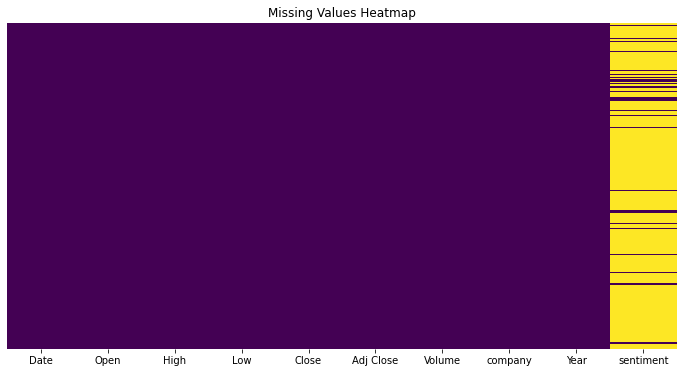

In [159]:

# visualisingmissing values

plt.figure(figsize=(12, 6))
sns.heatmap(final_goog.isna(), cbar=False, cmap="viridis", yticklabels=False)
plt.title("Missing Values Heatmap")
plt.show()


# 1. KNN-Based Mean Imputation (Univariate)
First imputation method is a custom KNN-style mean imputation. For each missing value in the sentiment time series, the function calculates the mean of the n nearest known past and future values (excluding the missing value itself). This method is univariate, relying solely on the sentiment column.

Pros: Simple and leverages local temporal context.

Cons: Ignores other potentially informative features.

/tmp/ipykernel_7608/3734446776.py:10: RuntimeWarning: Mean of empty slice
  out[i] = np.nanmean(ts_near)


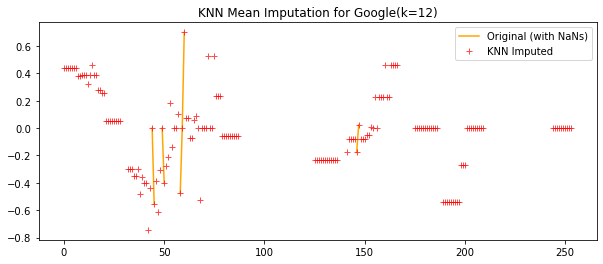

In [160]:
# Function to impute missing values using mean of n nearest past/future neighbors
def knn_mean(ts, n):
    out = np.copy(ts)
    for i, val in enumerate(ts):
        if np.isnan(val):
            n_by_2 = np.ceil(n / 2)
            lower = np.max([0, int(i - n_by_2)])
            upper = np.min([len(ts), int(i + n_by_2)])
            ts_near = np.concatenate([ts[lower:i], ts[i+1:upper]])  # skip current index
            out[i] = np.nanmean(ts_near)
    return out

# Apply the KNN mean imputation
final_goog['knn_mean'] = knn_mean(final_goog['sentiment'].values, 12)

# Plot
fig, ax = plt.subplots(figsize=(10, 4))
final_goog['sentiment'].plot(ax=ax, label='Original (with NaNs)', style='-', color='orange')
final_goog['knn_mean'].plot(ax=ax, label='KNN Imputed', style='+', color='red', alpha=0.7)
ax.set_title("KNN Mean Imputation for Google(k=12)")
ax.legend()
plt.show()
#final_goog['knn_mean'].isna().sum()

# 2. Multivariate KNN Imputation

Using sklearn's KNNImputer, a multivariate imputation method that utilizes additional features like Close and Volume was applied . 
This method considers the similarity of entire data points (rows) when imputing missing values.

Pros: Takes into account correlations with other variables.

Cons: May be sensitive to feature scaling or irrelevant features.

In [161]:
# importing imputer 
from sklearn.impute import KNNImputer

# Select features to use for imputation
features = ['sentiment', 'Close', 'Volume']
imputer = KNNImputer(n_neighbors=5)

# Fit and transform
imputed_array = imputer.fit_transform(final_goog[features])

# Replace original 'sentiment' with imputed one
final_goog['knn_imputer'] = imputed_array[:, 0]

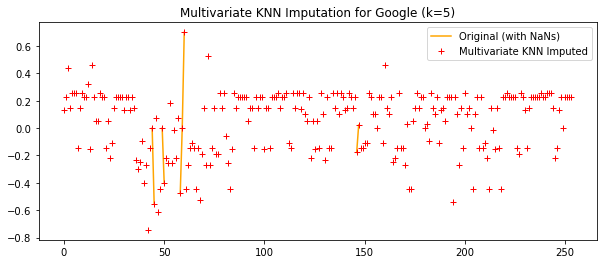

In [162]:
# visualise imputation 
fig, ax = plt.subplots(figsize=(10, 4))
final_goog['sentiment'].plot(ax=ax, label='Original (with NaNs)', style='-', color='orange')
final_goog['knn_imputer'].plot(ax=ax, label='Multivariate KNN Imputed', style='+', color='red')
ax.set_title("Multivariate KNN Imputation for Google (k=5)")
ax.legend()
plt.show()

# 3. Impute missing values based on Close percent Change
To impute missing sentiment values, the percentage change in the Close price is first calculated and scaled to a range of -1 to +1 using the tanh function. For rows with missing sentiment, the scaled percentage change is used to fill in the missing values. Any remaining NaN values in the sentiment_imputed column are backfilled with the next available value, ensuring that all missing sentiment values are properly imputed. Finally, the relevant columns (Close, Close_pct_change, sentiment, sentiment_imputed) are displayed for review.

In [163]:
# 1. Calculate percentage change in Close
final_goog['Close_pct_change'] = final_goog['Close'].pct_change()


# 2. Scale Close_pct_change to [-1, +1]
final_goog['Close_pct_change'] = np.tanh(final_goog['Close_pct_change'])

# 3. Create a new column for sentiment imputation, preserving original sentiment
final_goog['sentiment_imputed'] = final_goog['sentiment']

# 4. For missing sentiment values, replace with Close_pct_change
final_goog.loc[final_goog['sentiment'].isna(), 'sentiment_imputed'] = final_goog.loc[final_goog['sentiment'].isna(), 'Close_pct_change']

# 5. Fill remaining missing values (if any) using backfill
final_goog['sentiment_imputed'] = final_goog['sentiment_imputed'].bfill()

# 6. Display relevant columns
final_goog[['Close', 'Close_pct_change', 'sentiment', 'sentiment_imputed']]




,Close,Close_pct_change,sentiment,sentiment_imputed
0,66.850998,NaN,NaN,0.022696
1,68.368500,0.022696,NaN,0.022696
2,68.032997,-0.004907,0.4404,0.440400
3,69.710503,0.024652,NaN,0.024652
4,69.667000,-0.000624,NaN,-0.000624
...,...,...,...,...
249,86.942497,0.003735,0.0000,0.000000
250,88.804497,0.021413,NaN,0.021413
251,87.935997,-0.009780,NaN,-0.009780
252,86.975998,-0.010917,NaN,-0.010917


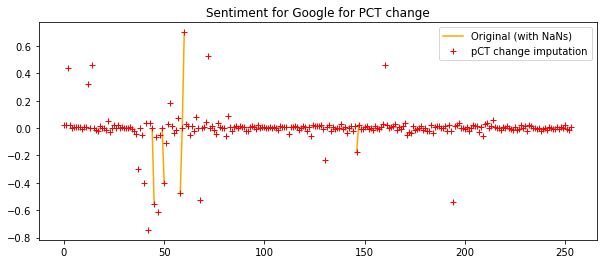

In [164]:
fig, ax = plt.subplots(figsize=(10, 4))
final_goog['sentiment'].plot(ax=ax, label='Original (with NaNs)', style='-', color='orange')
final_goog['sentiment_imputed'].plot(ax=ax, label='pCT change imputation', style='+', color='red')
ax.set_title("Sentiment for Google for PCT change")
ax.legend()
plt.show()

# 4. Linear Interpolation (Polynomial Order 1)
Finally, linear interpolation was used , which estimates missing values by fitting a straight line between known points. This is equivalent to a polynomial interpolation of order 1.

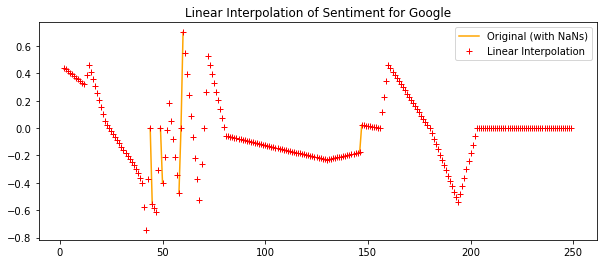

In [165]:
# Polynomial of degree 1 == linear, just for comparison
final_goog['sentiment_poly'] = final_goog['sentiment'].interpolate(method='polynomial', order=1)


fig, ax = plt.subplots(figsize=(10, 4))
final_goog['sentiment'].plot(ax=ax, label='Original (with NaNs)', style='-', color='orange')
final_goog['sentiment_poly'].plot(ax=ax, label='Linear Interpolation', style='+', color='red')
ax.set_title("Linear Interpolation of Sentiment for Google")
ax.legend()
plt.show()


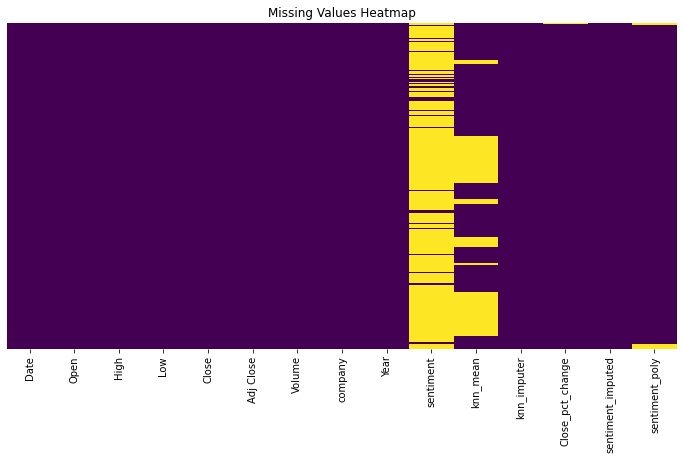

,Date,Open,High,Low,Close,Adj Close,Volume,company,Year,sentiment,knn_mean,knn_imputer,Close_pct_change,sentiment_imputed,sentiment_poly
0,2019-12-31,66.505501,66.900002,66.454247,66.850998,66.850998,19236000,GOOG,2019,NaN,0.4404,0.13354,NaN,0.022696,NaN
1,2020-01-02,67.077499,68.406998,67.077499,68.368500,68.368500,28132000,GOOG,2020,NaN,0.4404,0.22530,0.022696,0.022696,NaN
2,2020-01-03,67.392998,68.625000,67.277199,68.032997,68.032997,23728000,GOOG,2020,0.4404,0.4404,0.44040,-0.004907,0.440400,0.44040
3,2020-01-06,67.500000,69.824997,67.500000,69.710503,69.710503,34646000,GOOG,2020,NaN,0.4404,0.14502,0.024652,0.024652,0.42818
4,2020-01-07,69.897003,70.149498,69.518997,69.667000,69.667000,30054000,GOOG,2020,NaN,0.4404,0.25328,-0.000624,-0.000624,0.41596


In [166]:
#saving the final df and visualising the data 

final_goog.to_csv('final_goog.csv', index=False)


final_goog.columns

# visualisingmissing values

plt.figure(figsize=(12, 6))
sns.heatmap(final_goog.isna(), cbar=False, cmap="viridis", yticklabels=False)
plt.title("Missing Values Heatmap")
plt.show()

final_goog.head()


# Saving the final datasets to MongoDB

In [167]:


# Get all CSV files in the same directory that contain 'final' in the filename
csv_files = [f for f in os.listdir('.') if f.endswith('.csv') and 'final' in f.lower()]

try:
    for file in csv_files:
        company_name = os.path.splitext(file)[0]  # Extract company name from filename
        print(f"Reading and inserting: {file}")
        df = pd.read_csv(file)

        # Add a 'company' column to identify the source
        df['company'] = company_name

        records = df.to_dict(orient='records')
        
        if records:
            result = collection.insert_many(records)
            print(f"Inserted {len(result.inserted_ids)} records from {file}")
        else:
            print(f"No records found in {file}")

    # Display some of the inserted documents as a sample
    print("\nSample of Inserted Documents:")
    for doc in collection.find().limit(10):
        print(doc)

except Exception as e:
    print(f"An error occurred: {e}")

# Close the MongoDB connection
client.close()


Reading and inserting: final_amzn.csv
Inserted 254 records from final_amzn.csv
Reading and inserting: final_goog.csv
Inserted 254 records from final_goog.csv
Reading and inserting: final_meta.csv
Inserted 254 records from final_meta.csv
Reading and inserting: final_nflx.csv
Inserted 254 records from final_nflx.csv
Reading and inserting: final_aapl.csv
Inserted 254 records from final_aapl.csv
Reading and inserting: final.csv
Inserted 254 records from final.csv

Sample of Inserted Documents:
{'_id': ObjectId('6826f490992e4020cc9a9bac'), 'Date': '2019-12-31', 'Open': 66.50550079345703, 'High': 66.9000015258789, 'Low': 66.4542465209961, 'Close': 66.85099792480469, 'Adj Close': 66.85099792480469, 'Volume': 19236000, 'company': 'GOOG'}
{'_id': ObjectId('6826f490992e4020cc9a9bad'), 'Date': '2020-01-02', 'Open': 67.07749938964844, 'High': 68.40699768066406, 'Low': 67.07749938964844, 'Close': 68.36849975585938, 'Adj Close': 68.36849975585938, 'Volume': 28132000, 'company': 'GOOG'}
{'_id': Objec

# Streaming 

In [168]:
import praw

# Initialize Reddit API client
reddit = praw.Reddit(
    client_id="2tr7BU1vzTqbiEigVsrxbA",                              # Find from your Reddit account
    client_secret="pGDFTbWq4CIE3_Bx6vrum9pMZ85m9Q",                  # Create username and find your own client secret
    user_agent='BDSP:v1.0 (by /u/Big_Brilliant_9638)'           # Custom user agent with your Reddit username
                                                                     # BDSPDataCollector is the name provided by you
)

# Test: Fetch latest posts from a subreddit (e.g., "worldnews")
subreddit = reddit.subreddit("stocks")
for post in subreddit.new(limit=50):
    print(f"Title: {post.title}")
    print(f"Score: {post.score}")
    print(f"Author: {post.author}")
    print(f"Created UTC: {post.created_utc}")
    print(f"Selftext: {post.selftext}")
    print("-" * 50)

Title: The SP will hit 7000 by year’s end
Score: 0
Author: InjuryEmbarrassed532
Created UTC: 1747375948.0
Selftext: I am bullish on the rest of the year, tariffs are a nothing burger that will have no effect on the US tech driven stock market. 
No one knows what will happen, but in my opinions value and cash bros are about to learn a lesson on par with what they should have already learned starting back in 2010. 

Some of the reasons why I think we will reach new highs.

1. De-Dollarization Backfires and U.S. Markets Become the Last Safe Haven
As countries diversify away from the U.S. dollar, capital might not flow into gold or emerging markets as expected—but instead flood into U.S. equities, especially large-cap tech. In this view, the U.S. remains the most liquid, transparent, and innovation-driven market. Ironically, global distrust of U.S. fiscal policy could boost stocks as foreign capital chases yield and safety in equities, not Treasuries.


2. The AI Productivity Supercycle Is

In [169]:
import praw
import json
from datetime import datetime

# Initialize Reddit API client
reddit = praw.Reddit(
    client_id="2tr7BU1vzTqbiEigVsrxbA",                              # Find from your Reddit account
    client_secret="pGDFTbWq4CIE3_Bx6vrum9pMZ85m9Q",                  # Create username and find your own client secret
    user_agent='BDSP:v1.0 (by /u/Big_Brilliant_9638)'           # Custom user agent with your Reddit username
                                                                     # BDSPDataCollector is the name provided by you
)
# Fetch latest posts from the subreddit and store in a local file
# Other topics: Economics, Business
def fetch_and_store_reddit_data(subreddit_name="stocks"):
    subreddit = reddit.subreddit(subreddit_name)
    posts = []
    for post in subreddit.new(limit=50):  # Limit to 10 posts
        post_data = {
            "id": post.id,
            "title": post.title,
            "author": post.author.name if post.author else None,
            "created_utc": post.created_utc,
            "selftext": post.selftext,
            "score": post.score,
            "comments": post.num_comments
        }
        posts.append(post_data)
    
    # Convert posts to JSON
    posts_json = json.dumps(posts, indent=4)
    
    # Define a fixed filename for overwriting
    local_filename = "/home/hduser/Desktop/stocks_posts.json"
    
    # Write to local file system (this will overwrite the file each time)
    with open(local_filename, 'w') as local_file:
        local_file.write(posts_json)
    
    print(f"Data written to local file: {local_filename}")

# Call the function to fetch and store Reddit data
fetch_and_store_reddit_data("stocks")

Data written to local file: /home/hduser/Desktop/stocks_posts.json


In [170]:
import praw
import json
from datetime import datetime
from pyspark.sql import SparkSession
from pyspark.sql.functions import explode, split, lower, col, desc
import os
from pyspark.ml.feature import StopWordsRemover


# Initialize Reddit API client
reddit = praw.Reddit(
    client_id="2tr7BU1vzTqbiEigVsrxbA",                              # Find from your Reddit account
    client_secret="pGDFTbWq4CIE3_Bx6vrum9pMZ85m9Q",                  # Create username and find your own client secret
    user_agent='BDSP:v1.0 (by /u/Big_Brilliant_9638)'           # Custom user agent with your Reddit username
                                                                     # BDSPDataCollector is the name provided by you
)

# Fetch Reddit posts
def fetch_and_store_reddit_data(subreddit_name="stocks"):
    subreddit = reddit.subreddit(subreddit_name)
    posts = []
    for post in subreddit.new(limit=50):  # Limit to 50 posts
        post_data = {
            "id": post.id,
            "title": post.title,
            "author": post.author.name if post.author else None,
            "created_utc": post.created_utc,
            "selftext": post.selftext,
            "score": post.score,
            "comments": post.num_comments
        }
        posts.append(post_data)

    # Set a consistent filename for the posts (appending to same file)
    local_filename = f"/home/hduser/Desktop/{subreddit_name}_posts.json"

    # Append to the same file
    with open(local_filename, 'a') as local_file:
        for post in posts:
            json.dump(post, local_file)
            local_file.write("\n")  # Newline delimiter between posts

    print(f"Data written to local file: {local_filename}")

# Initialize Spark session
spark = SparkSession.builder \
    .appName("RedditWordFrequency") \
    .master("local[*]") \
    .getOrCreate()

# Define file path (using the same consistent filename)
file_path = "file:///home/hduser/Desktop/stocks_posts.json"  # Replace with your actual path if needed

# Step 1: Load the Reddit JSON data
reddit_df = spark.read.option("multiLine", "true").json(file_path)

# Step 2: Extract title and selftext, combine them for word analysis
reddit_text_df = reddit_df.selectExpr("concat(coalesce(title, ''), ' ', coalesce(selftext, '')) as text")


# Step 3: Split the text into an array of lowercase words
split_df = reddit_text_df.select(
    split(lower(col("text")), "\\W+").alias("words")
)

# Step 4: Remove stop words
remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")
filtered_df = remover.transform(split_df)

# Step 5: Explode words and remove empty strings
words_df = filtered_df.select(explode(col("filtered_words")).alias("word"))
words_df = words_df.filter(col("word") != "")


# Step 6: Count the frequency of each word
word_count_df = words_df.groupBy("word").count().orderBy(desc("count"))

# Show top 20 words
word_count_df.show(20, truncate=False)

# Step 6: Find the word(s) that appeared maximum number of times
max_count = word_count_df.agg({"count": "max"}).collect()[0][0]

print(f"\nWord(s) with maximum occurrence ({max_count} times):")
word_count_df.filter(col("count") == max_count).show(truncate=False)

# Stop Spark session
spark.stop()

# Call the function to fetch and store Reddit data for 'stocks'
fetch_and_store_reddit_data("stocks")  


25/05/16 09:18:38 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


+-------+-----+
|word   |count|
+-------+-----+
|stock  |44   |
|tesla  |37   |
|https  |34   |
|like   |33   |
|com    |32   |
|market |32   |
|2      |31   |
|said   |28   |
|year   |27   |
|even   |27   |
|company|27   |
|1      |25   |
|www    |24   |
|stocks |23   |
|new    |23   |
|3      |23   |
|ai     |22   |
|years  |22   |
|price  |22   |
|buy    |21   |
+-------+-----+
only showing top 20 rows


Word(s) with maximum occurrence (44 times):
+-----+-----+
|word |count|
+-----+-----+
|stock|44   |
+-----+-----+

Data written to local file: /home/hduser/Desktop/stocks_posts.json


## Collect the data for 90 seconds on Reddit

In [171]:
import praw
import json
import time
from datetime import datetime
from pyspark.sql import SparkSession
from pyspark.sql.functions import explode, split, lower, col, desc

# Initialize Reddit API client
reddit = praw.Reddit(
    client_id="2tr7BU1vzTqbiEigVsrxbA",                              # Find from your Reddit account
    client_secret="pGDFTbWq4CIE3_Bx6vrum9pMZ85m9Q",                  # Create username and find your own client secret
    user_agent='BDSP:v1.0 (by /u/Big_Brilliant_9638)'           # Custom user agent with your Reddit username
                                                                     # BDSPDataCollector is the name provided by you
)
# Initialize Spark Session
spark = SparkSession.builder \
    .appName("RedditLiveAnalytics") \
    .master("local[*]") \
    .getOrCreate()

# Function to fetch Reddit posts for 90 seconds
def fetch_reddit_posts(duration_sec=90, subreddit_name="stocks"):
    print(f"\nFetching posts from r/{subreddit_name} for {duration_sec} seconds...")
    posts = []
    start_time = time.time()
    while (time.time() - start_time) < duration_sec:
        try:
            subreddit = reddit.subreddit(subreddit_name)
            for post in subreddit.new(limit=5):  # Fetch latest 5 posts quickly
                post_data = {
                    "id": post.id,
                    "title": post.title,
                    "selftext": post.selftext if post.selftext else ""
                }
                posts.append(post_data)
            time.sleep(5)  # Sleep for 5 seconds to avoid hitting API too fast
        except Exception as e:
            print(f"Error fetching posts: {e}")
            time.sleep(5)
    return posts

# Function to analyze posts with PySpark
def analyze_posts(posts):
    if not posts:
        print("No posts to analyze.")
        return
    # Create a temporary JSON file
    temp_filename = f"/tmp/reddit_temp_{datetime.now().strftime('%Y%m%d_%H%M%S')}.json"
    with open(temp_filename, 'w') as f:
        for post in posts:
            json.dump(post, f)
            f.write("\n")  # Newline-delimited JSON (NDJSON)
    
    # Read with Spark
    reddit_df = spark.read.json(f"file://{temp_filename}")
    
    reddit_text_df = reddit_df.selectExpr("concat(coalesce(title, ''), ' ', coalesce(selftext, '')) as text")
    
        # Step 1: Split into words
    split_df = reddit_text_df.select(
        split(lower(col("text")), "\\W+").alias("words")
    )

    # Step 2: Remove stop words
    remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")
    filtered_df = remover.transform(split_df)

    # Step 3: Explode words and remove empty strings
    words_df = filtered_df.select(explode(col("filtered_words")).alias("word"))
    words_df = words_df.filter(col("word") != "")

    
    word_count_df = words_df.groupBy("word").count().orderBy(desc("count"))
    
    print("\nTop 20 Words:")
    word_count_df.show(20, truncate=False)
    
    max_count = word_count_df.agg({"count": "max"}).collect()[0][0]
    print(f"\nWord(s) with maximum occurrence ({max_count} times):")
    word_count_df.filter(col("count") == max_count).show(truncate=False)

# Main loop
while True:
    posts = fetch_reddit_posts(duration_sec=90)
    analyze_posts(posts)
    
    choice = input("\nDo you want to fetch and analyze again? (yes/no): ").strip().lower()
    if choice != 'yes':
        print("Exiting program. Thank you for using this Pyspark Application for real time analytics")
        break

# Stop Spark session
spark.stop()


Fetching posts from r/stocks for 90 seconds...

Top 20 Words:
+---------+-----+
|word     |count|
+---------+-----+
|yield    |108  |
|u        |108  |
|hysa     |90   |
|like     |90   |
|market   |72   |
|currently|72   |
|year     |72   |
|buy      |54   |
|stocks   |54   |
|foot     |54   |
|great    |54   |
|markets  |54   |
|put      |54   |
|guidance |54   |
|cash     |54   |
|years    |54   |
|mmt      |54   |
|stock    |54   |
|money    |54   |
|sgov     |54   |
+---------+-----+
only showing top 20 rows


Word(s) with maximum occurrence (108 times):
+-----+-----+
|word |count|
+-----+-----+
|yield|108  |
|u    |108  |
+-----+-----+


Do you want to fetch and analyze again? (yes/no): no
Exiting program. Thank you for using this Pyspark Application for real time analytics


In [172]:
import subprocess

# Function to check if HDFS is running
def check_hdfs():
    try:
        # Run the jps command to check the status of Hadoop services
        result = subprocess.run(["jps"], stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
        
        # Check if 'NameNode' and 'DataNode' appear in the jps output
        if "NameNode" in result.stdout and "DataNode" in result.stdout:
            return True  # HDFS is running
        else:
            return False  # HDFS is not running
    except Exception as e:
        print(f"Error checking HDFS status: {e}")
        return False

# Function to start HDFS if it's not running
def start_hdfs():
    print("Starting HDFS...")
    subprocess.run(["start-dfs.sh"], check=True)
    subprocess.run(["start-yarn.sh"], check=True)

# Check if HDFS is running
if check_hdfs():
    print("HDFS is already running.")
else:
    start_hdfs()

HDFS is already running.


In [173]:
# Checking pyspark is running 
!jps

7620 SparkSubmit
8980 Jps
6406 SecondaryNameNode
6090 NameNode
6829 NodeManager
6222 DataNode


In [174]:
import praw
import json
from datetime import datetime
from hdfs import InsecureClient

# Initialize Reddit API client
reddit = praw.Reddit(
    client_id="2tr7BU1vzTqbiEigVsrxbA",                              # Find from your Reddit account
    client_secret="pGDFTbWq4CIE3_Bx6vrum9pMZ85m9Q",                  # Create username and find your own client secret
    user_agent='BDSP:v1.0 (by /u/Big_Brilliant_9638)'           # Custom user agent with your Reddit username
                                                                     # BDSPDataCollector is the name provided by you
)

# Initialize HDFS client (adjust URL and user if necessary)
hdfs_client = InsecureClient('http://localhost:9870')

# Fetch latest posts from the subreddit and store in a local file
def fetch_and_store_reddit_data(subreddit_name="stocks"):
    subreddit = reddit.subreddit(subreddit_name)
    posts = []
    
    for post in subreddit.new(limit=10):  # Limit to 10 posts
        post_data = {
            "id": post.id,
            "title": post.title,
            "author": post.author.name if post.author else None,
            "created_utc": post.created_utc,
            "selftext": post.selftext,
            "score": post.score,
            "comments": post.num_comments
        }
        posts.append(post_data)
    
    # Convert posts to JSON
    posts_json = json.dumps(posts, indent=4)
    
    # Create a filename based on the current date and time for local storage on Desktop
    local_filename = f"/home/hduser/Desktop/{subreddit_name}_posts_{datetime.now().strftime('%Y%m%d_%H%M%S')}.json"
    
    # Write to local file system
    with open(local_filename, 'w') as local_file:
        local_file.write(posts_json)
    
    print(f"Data written to local file: {local_filename}")

    # Upload the local file to HDFS
    # Name of the file should be different each time as we cannot overwrite on hdfs
    hdfs_file_path = f"/user1/{subreddit_name}_posts_{datetime.now().strftime('%Y%m%d_%H%M%S')}.json"
    hdfs_client.upload(hdfs_file_path, local_filename)
    
    print(f"Data uploaded to HDFS at: {hdfs_file_path}")

# Call the function to fetch and store Reddit data
fetch_and_store_reddit_data("stocks")

Data written to local file: /home/hduser/Desktop/stocks_posts_20250516_092025.json
Data uploaded to HDFS at: /user1/stocks_posts_20250516_092025.json
